### Loads required R libraries

In [628]:
library(rlang)
for(RPkg in c("DBI", "ggplot2", "plyr", "dplyr", "pander", "Metrics","summarytools", "tidyverse", "corrr", "PerformanceAnalytics",
             "corrplot", "stringi", "rpart.plot", "Hmisc", "ggcorrplot", "sqldf", "RMariaDB" , "gclus", "psych", "viridis", 
             "forestmangr", "nortest", "tidyquant", "tseries", "plotly", "lubridate", "randomForest","rms", "MASS", "caret", "rpart", "scales", 
             "purrr", "caTools", "tidyr", "stringr", "gdata")){
  eval(bquote(library(.(RPkg))))
}

### Makes connection to the back end MySQL database after reading its password file from the filesystem. MySQL database is located on an AWS RDS instance. <span style="color:red">*Global path change to run*</span>

In [657]:
# change the path to the filesystem location where you decide to save the SQLite database

mysqldb.connStrfile<-"C:\\Users\\Stavros Kalamatianos\\Downloads\\GMU\\Courses\\CS504\\Project\\passwd.txt"
mysqldb.db<-"SMIL"
dbConn<-dbConnect(RMariaDB::MariaDB(),default.file=mysqldb.connStrfile,group=mysqldb.db)

dbListTables(dbConn)

[1] "AllAcornGroups"                       
 [2] "acorn_details"                        
 [3] "acorn_details_transp"                 
 [4] "daily_dataset"                        
 [5] "daily_dataset_hhblocks_byACORN"       
 [6] "daily_dataset_hhblocks_byACORN_transp"
 [7] "daily_dataset_hhblocks_byHour"        
 [8] "hhblock"                              
 [9] "info_hous_Acorn"                      
[10] "informations_households"              
[11] "informations_households_revamped"     
[12] "tariffs"                              
[13] "uk_bank_holidays"                     
[14] "weather_daily_darksky"                
[15] "weather_hourly_darksky"

#### Builds a function that takes vector of values as an input it calculates their IQR and the quantiles, and then the cut-off ranges beyond which all data points are considered outliers. Its output is 3 values: upper and lower outlier cut-off values and the mean of the vector values excluding the outliers

In [630]:
outlierLessAvg <- function(v){
    q <- quantile(v, probs=c(.25, .75), na.rm = TRUE)
    iqr <- IQR(v)
    
    upper <-  q[2]+1.5*iqr # upper outlier cutoff  
    lower <- q[1]-1.5*iqr  # lower outlier cutoff
    
    m <- v[v<upper][v>lower]
    m <- m[!is.na(m)]
    
    mn <- mean(m, trim=0, na.rm = TRUE)
    mn <- as.numeric(format(round(mn, 2), nsmall = 2))
    
    results <- shapiro.test(v[!is.na(v)])
    SWstatistic <- as.numeric(gsub('.*-([0-9]+).*','\\1',results$statistic))
    SWpValue <- as.numeric(results$p.value)

    r <- c(lower, upper, mn, SWstatistic, SWpValue)
    return(r)
}

#### Sums each half hour interval's energy consumption recordings from all Smart Meters by Date 

In [631]:
hhblocks <- dbGetQuery(dbConn, 
"
select hh1.day, hh2.numbSmMtrs, hh_0, hh_1, hh_2, hh_3, hh_4, hh_5, hh_6, hh_7, hh_8, hh_9, hh_10, hh_11, hh_12, hh_13, hh_14, hh_15, hh_16, hh_17, hh_18, hh_19, hh_20, hh_21, hh_22, hh_23, hh_24, hh_25, hh_26, hh_27, hh_28, hh_29, hh_30, hh_31, hh_32, hh_33, hh_34, hh_35, hh_36, hh_37, hh_38, hh_39, hh_40, hh_41, hh_42, hh_43, hh_44, hh_45, hh_46, hh_47
from 
(
    select day, sum(hh_0) as hh_0, sum(hh_1) as hh_1,  sum(hh_2) as hh_2,  sum(hh_3) as hh_3,  sum(hh_4) as hh_4,  sum(hh_5) as hh_5,  sum(hh_6) as hh_6,  sum(hh_7) as hh_7,  sum(hh_8) as hh_8,  sum(hh_9) as hh_9,  sum(hh_10) as hh_10,  sum(hh_11) as hh_11,  sum(hh_12) as hh_12,  sum(hh_13) as hh_13,  sum(hh_14) as hh_14,  sum(hh_15) as hh_15,  sum(hh_16) as hh_16,  sum(hh_17) as hh_17,  sum(hh_18) as hh_18,  sum(hh_19) as hh_19,  sum(hh_20) as hh_20,  sum(hh_21) as hh_21,  sum(hh_22) as hh_22,  sum(hh_23) as hh_23,  sum(hh_24) as hh_24,  sum(hh_25) as hh_25,  sum(hh_26) as hh_26,  sum(hh_27) as hh_27,  sum(hh_28) as hh_28,  sum(hh_29) as hh_29,  sum(hh_30) as hh_30,  sum(hh_31) as hh_31,  sum(hh_32) as hh_32,  sum(hh_33) as hh_33,  sum(hh_34) as hh_34,  sum(hh_35) as hh_35,  sum(hh_36) as hh_36,  sum(hh_37) as hh_37,  sum(hh_38) as hh_38,  sum(hh_39) as hh_39,  sum(hh_40) as hh_40,  sum(hh_41) as hh_41,  sum(hh_42) as hh_42,  sum(hh_43) as hh_43,  sum(hh_44) as hh_44,  sum(hh_45) as hh_45,  sum(hh_46) as hh_46,  sum(hh_47) as hh_47
    from hhblock
    group by day
) as hh1
left outer join
(
    select day, count(distinct LCLid) as numbSmMtrs
    from hhblock
    group by day
) as hh2
on hh1.day = hh2.day
;
"
)

#### Replaces all blank spaces or single white spaces with NAs across the last created data frame

In [632]:
# which(is.na(as.numeric(as.character(hhblocks[2:48]))))
# hhblocks[,3:50][hhblocks[,3:50]==""]<-NA
# hhblocks[,3:50][hhblocks[,3:50]==" "]<-NA

#### Horizontal expansion of last created data frame with columns for lower and upper outlier cutoff limits, their outlier-less mean and the Shapiro Test Normality test results. Each record of the data frame is the collection of the 48 1/2 hr energy consumption sum from all Smart Meter readings for a specific date  

In [633]:
hhblocks_stats <- cbind(hhblocks[,1:50], apply(hhblocks[,3:50], 1, outlierLessAvg)[1,], apply(hhblocks[,3:50], 1, outlierLessAvg)[2,], apply(hhblocks[,3:50], 1, outlierLessAvg)[3,], apply(hhblocks[,3:50], 1, outlierLessAvg)[4,], apply(hhblocks[,3:50], 1, outlierLessAvg)[5,])

# assigns column names to appended columns and renames column 1
names(hhblocks_stats)[1] <-  'time'
names(hhblocks_stats)[51] <- 'lowerOutlCutoff'
names(hhblocks_stats)[52] <- 'upperOutlCutoff'
names(hhblocks_stats)[53] <- 'outlierLessAvg'
names(hhblocks_stats)[54] <- 'SWstatistic'
names(hhblocks_stats)[55] <- 'SWpValue'
hhblocks_stats$outlierLessAvg <- hhblocks_stats$outlierLessAvg/hhblocks$numbSmMtrs

#### Changes 'time' column data type, trims it and then splits it to date and time

In [634]:
hhblocks_stats$time <- as.character(hhblocks_stats$time)
hhblocks_stats$time <- trim(hhblocks_stats$time)
hhblocks_stats <- hhblocks_stats %>% mutate(time = str_replace(time, " ", "|")) %>% separate(time, into = c("timeDate", "timeTime"), sep = "\\|")

Warning message:
"Expected 2 pieces. Missing pieces filled with `NA` in 827 rows [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, ...]."


In [635]:
head(hhblocks_stats)

,timeDate,timeTime,numbSmMtrs,hh_0,hh_1,hh_2,hh_3,hh_4,hh_5,hh_6,...,hh_43,hh_44,hh_45,hh_46,hh_47,lowerOutlCutoff,upperOutlCutoff,outlierLessAvg,SWstatistic,SWpValue
,<chr>,<chr>,<int64>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2012-10-13,NA,5253,735.976,771.656,714.122,648.385,604.346,584.566,560.687,...,1371.088,1259.774,1124.412,997.150,882.186,18.98337,2006.844,0.2103560,0.9413785,0.018341360
2,2012-10-14,NA,5254,785.758,831.212,753.734,697.344,657.647,619.449,599.709,...,1431.362,1283.335,1088.143,918.146,798.433,-13.89237,2143.859,0.2238295,0.9339989,0.009602266
3,2012-10-15,NA,5242,707.531,761.387,692.033,646.734,604.187,575.239,563.399,...,1452.578,1282.533,1084.543,920.164,786.483,77.21025,2002.232,0.2128958,0.9338602,0.009488000
4,2012-10-16,NA,5054,689.561,738.411,685.369,623.503,585.420,570.832,556.718,...,1384.051,1231.221,1060.489,904.134,772.458,77.80913,1925.668,0.2071626,0.9246116,0.004339407
5,2012-10-17,NA,5240,707.208,757.349,701.998,647.263,604.610,577.593,563.554,...,1399.645,1241.758,1068.284,899.333,766.099,97.51113,1910.048,0.2038168,0.9208770,0.003192571
6,2012-10-18,NA,4905,641.390,679.499,626.821,571.881,538.787,514.424,509.666,...,1290.638,1153.053,995.804,853.333,733.148,106.09500,1768.539,0.1991845,0.9280337,0.005774697


#### Plots Shapiro Test statistics vs Time

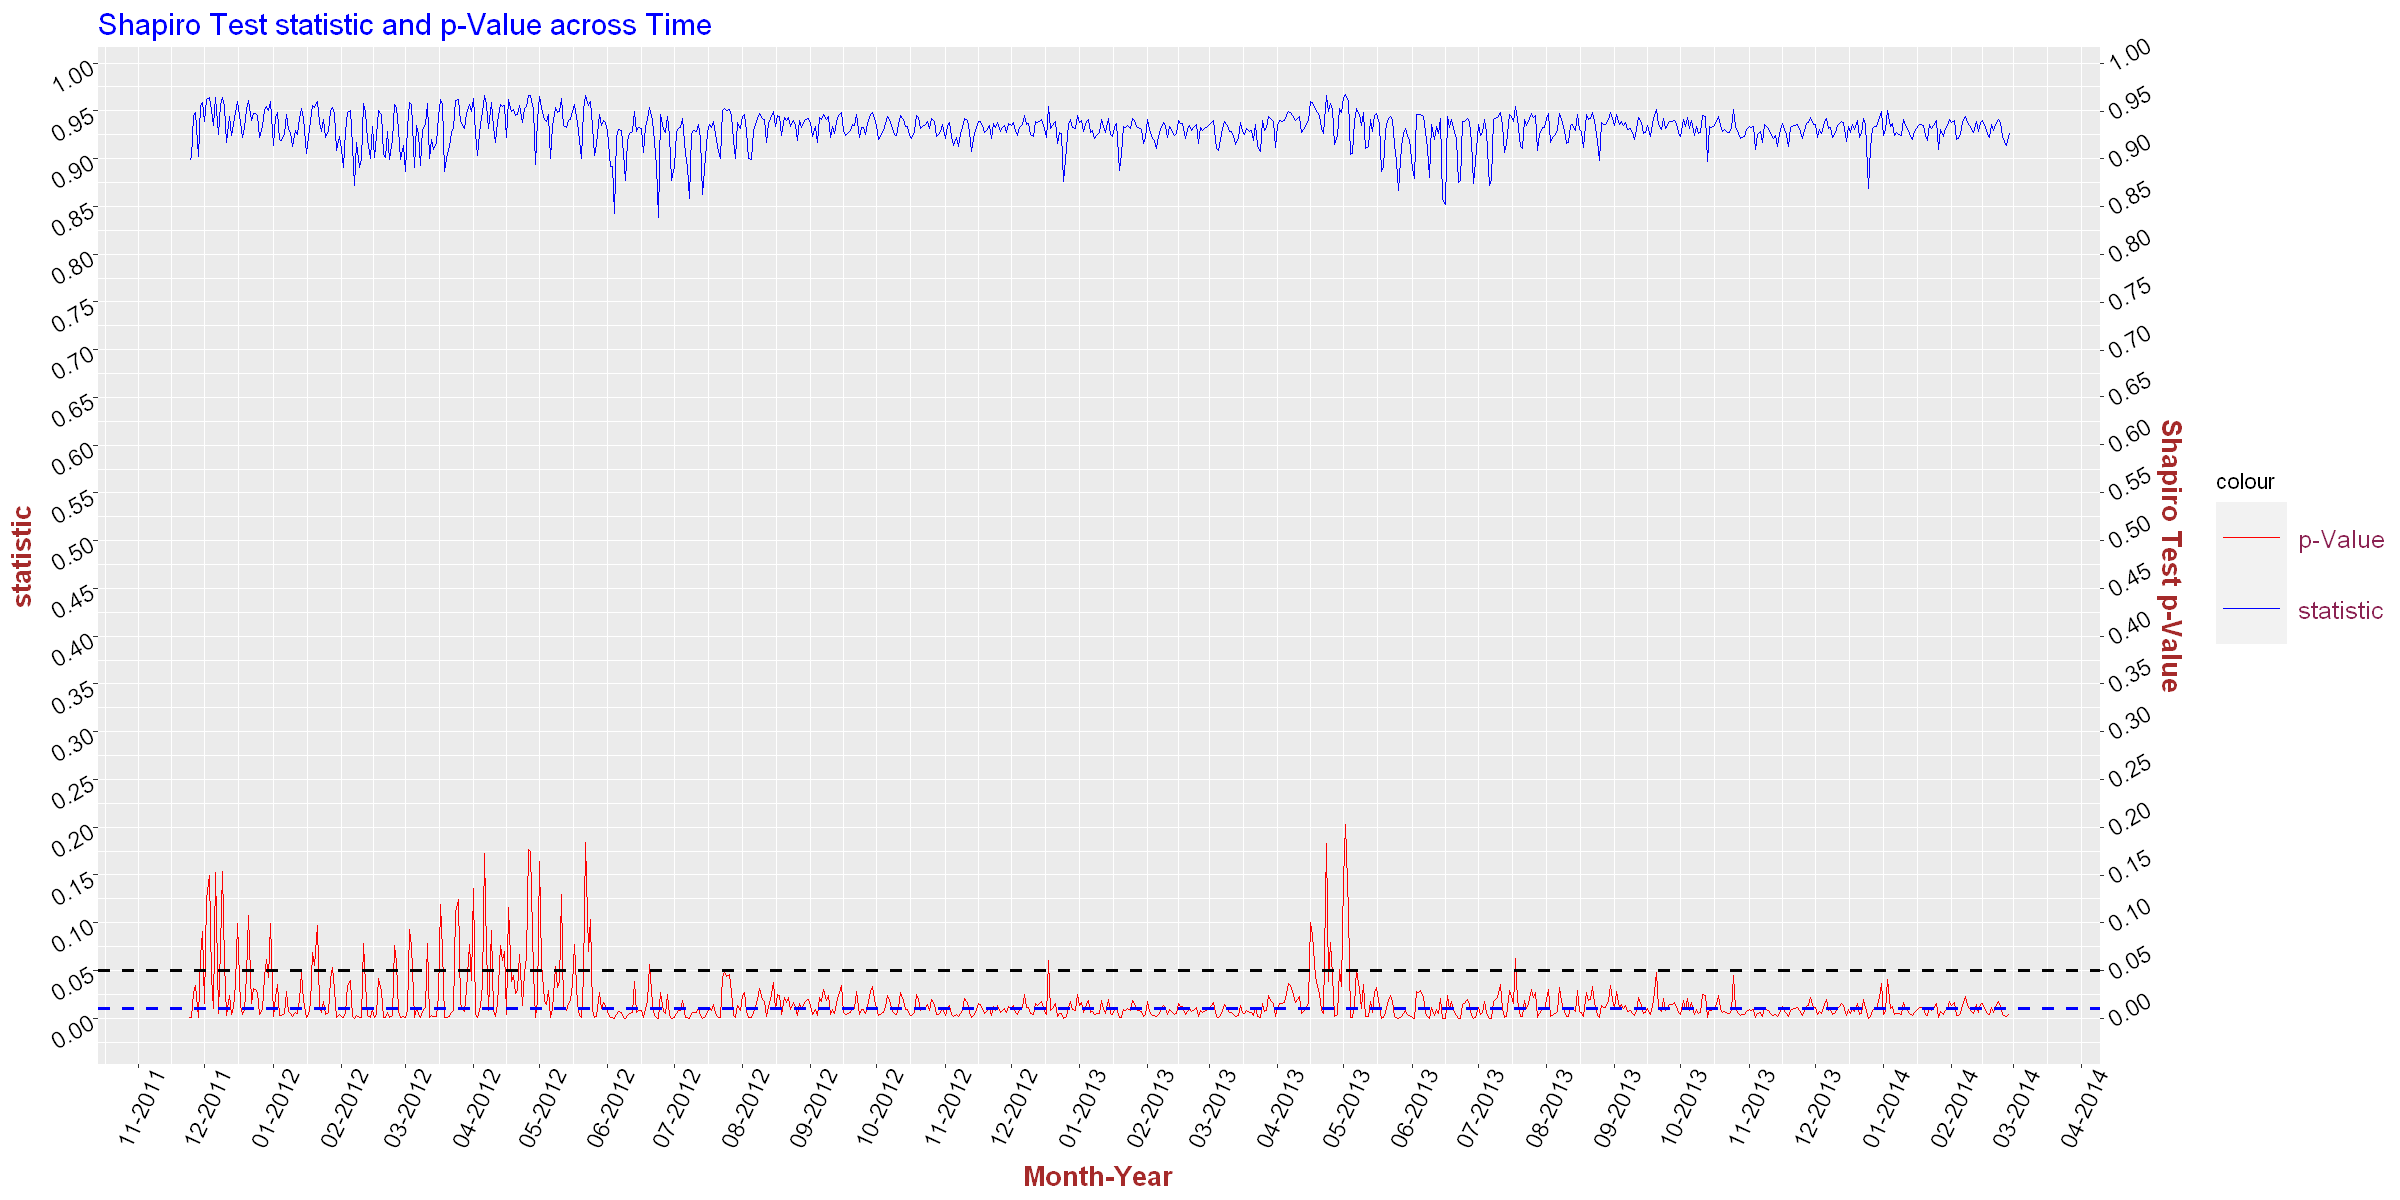

In [644]:
options(repr.plot.width = 20, repr.plot.height = 10)

vars <- c("timeDate", "SWstatistic", "SWpValue")
hhblocks_stats_sub <- hhblocks_stats[vars]

hhblocks_stats_sub$timeDate <- as.Date(hhblocks_stats_sub$timeDate)

ggplot()+   
  geom_line(data=hhblocks_stats_sub, aes(x=timeDate,y=SWstatistic,col="Shapiro Test statistic"))+
  scale_y_continuous(breaks=seq(0,1,0.05), sec.axis = sec_axis(~.*1, name = "Shapiro Test p-Value", breaks=seq(0,1,0.05)))+
  scale_x_date(date_breaks = "months" , date_labels = "%m-%Y")+
  geom_line(data=hhblocks_stats_sub, aes(x=timeDate, y=SWpValue, col="Shapiro Test p-value"))+
  geom_hline(yintercept=0.05, linetype="dashed", color = "black", size = 1) +
  geom_hline(yintercept=0.01, linetype="dashed", color = "blue", size = 1) +
  scale_color_manual(values=c("red","blue"),
                     labels=c("p-Value","statistic"))+
  labs(title = "Shapiro Test statistic and p-Value across Time",
       x = "Month-Year",
       y = "statistic") +
theme(axis.text.x = element_text(size=14, angle=65, vjust=0.6, color="black"), 
        axis.text.y = element_text(size=14, angle=30, vjust=0.6, color="black"),
        axis.title=element_text(size=16, face="bold", color="brown"),
        plot.caption = element_text(color= "red", size=14, angle=0, vjust=0.6),
        plot.title = element_text(color= "blue", size=18, angle=0, vjust=0.6),
        plot.subtitle = element_text(color= "blue", size=14, angle=0, vjust=0.6, face="italic"),
        legend.title = element_text(size = 13), legend.text = element_text(color = "violetred4", size = 15), 
        legend.key.size = unit(1.5, "cm"), legend.key.width = unit(1.5,"cm"))

#### Plots Shapiro Test statistic vs p-value for all dates

Warning message:
"Ignoring unknown parameters: linetype"


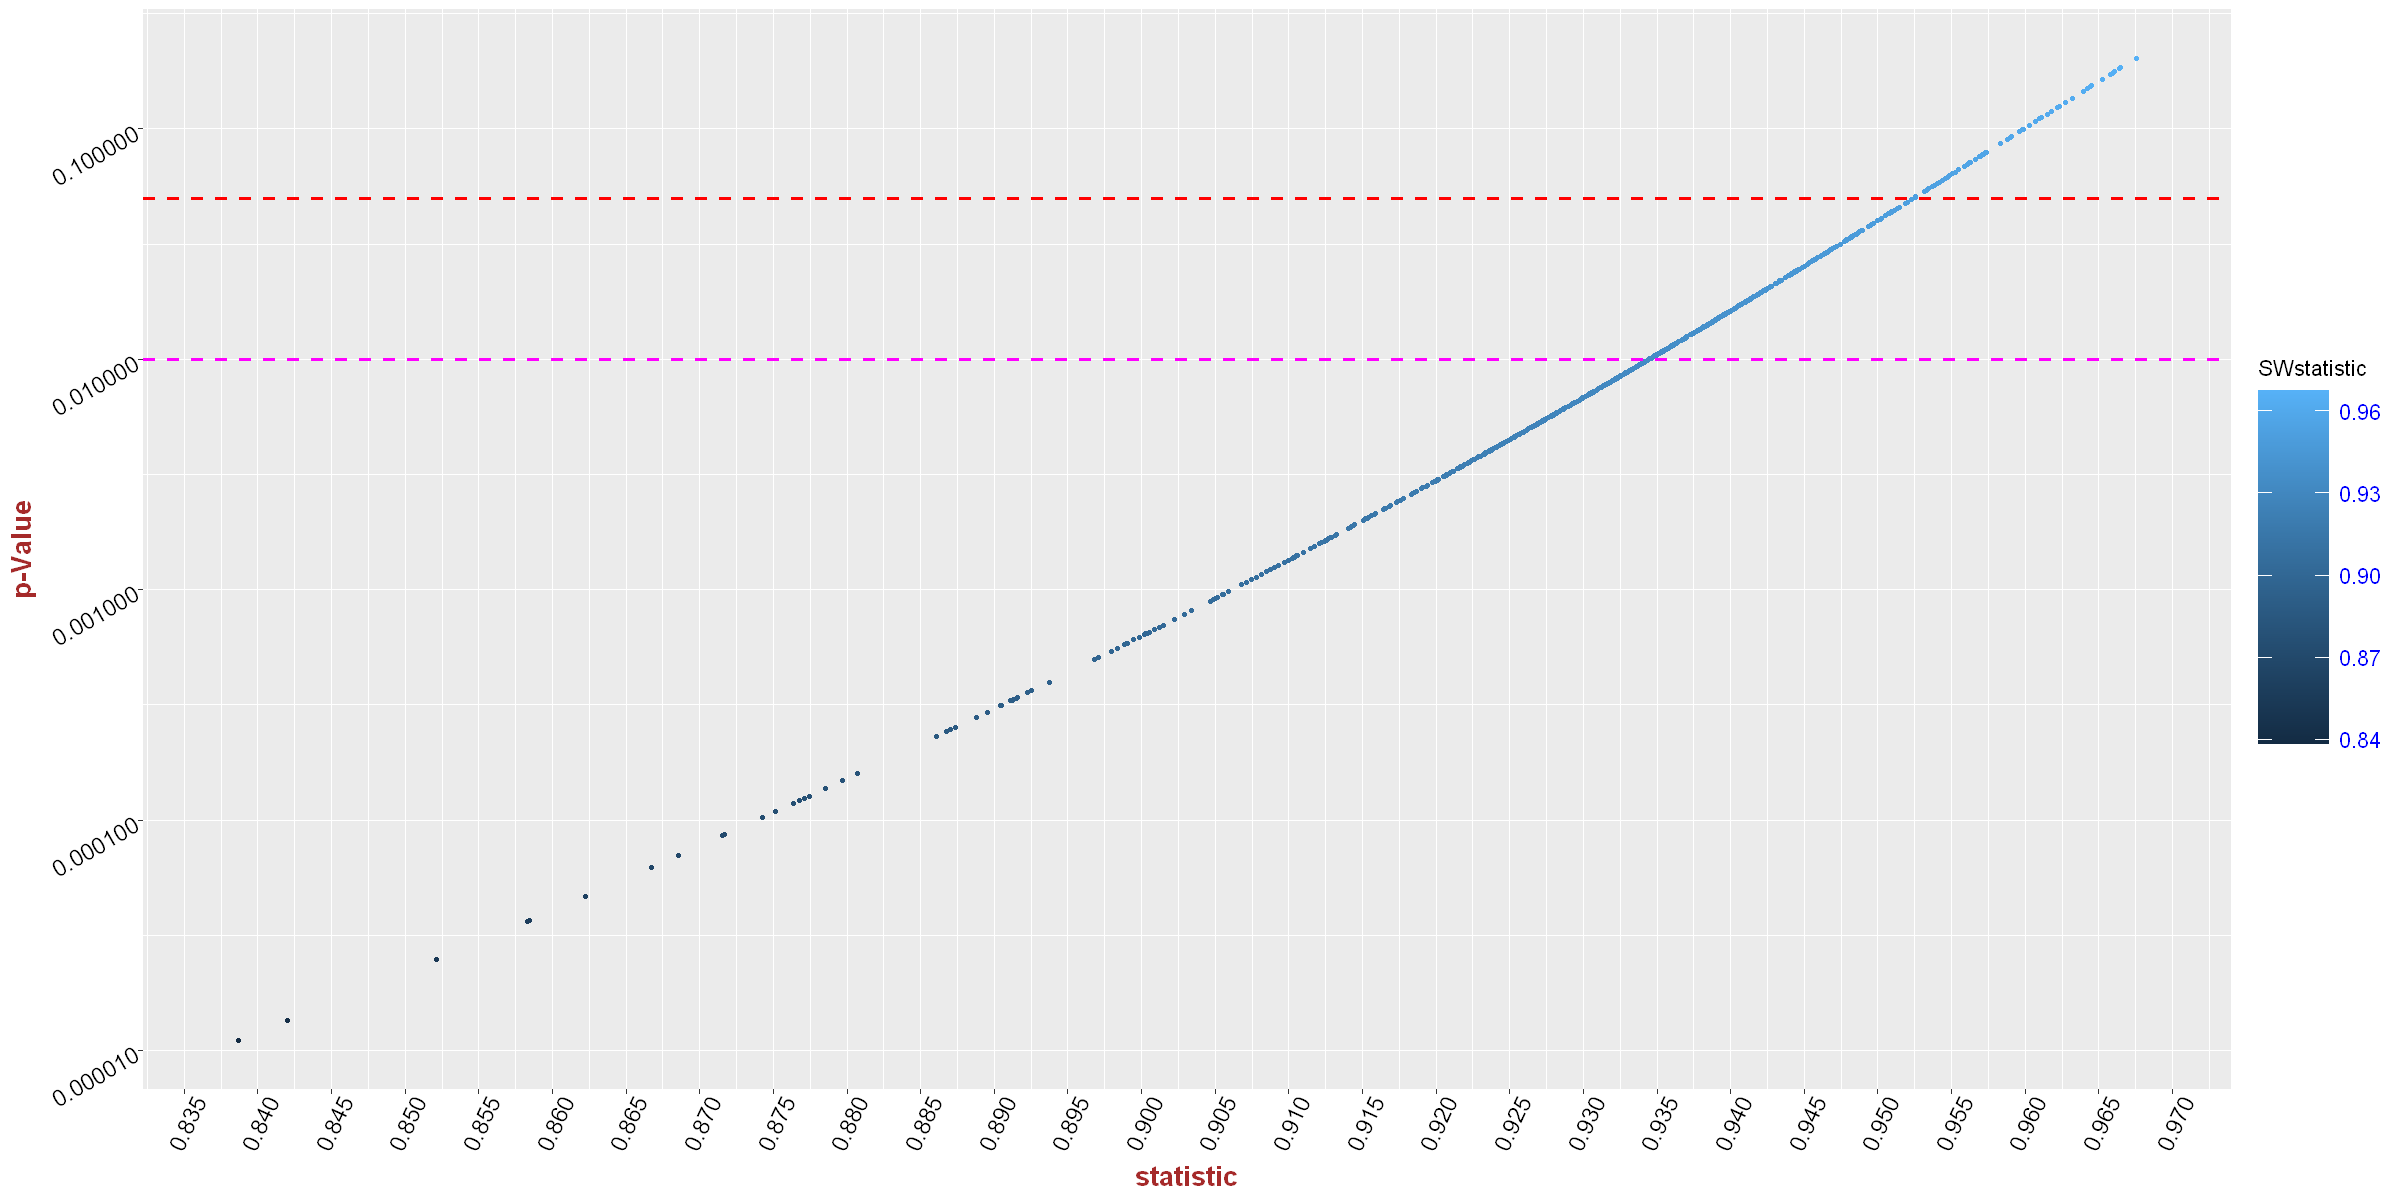

In [638]:
ggplot(data = hhblocks_stats_sub, aes(x = SWstatistic, y = SWpValue)) +
  geom_point(aes(color = SWstatistic), size=1.2, linetype = "solid") + 
  labs(x='statistic', y='p-Value') +
  geom_hline(yintercept=0.05, linetype="dashed", color = "red", size = 1) +
  geom_hline(yintercept=0.01, linetype="dashed", color = "magenta", size = 1) +
 theme(axis.text.x = element_text(size=14, angle=65, vjust=0.6, color="black"), 
        axis.text.y = element_text(size=14, angle=30, vjust=0.6, color="black"),
        axis.title=element_text(size=16, face="bold", color="brown"),
        plot.caption = element_text(color= "red", size=14, angle=0, vjust=0.6),
        plot.title = element_text(color= "blue", size=14, angle=0, vjust=0.6),
        plot.subtitle = element_text(color= "blue", size=14, angle=0, vjust=0.6, face="italic"),
        legend.title = element_text(size = 13), legend.text = element_text(color = "blue", size = 13), 
        legend.key.size = unit(1.5, "cm"), legend.key.width = unit(1.5,"cm")) +
  scale_y_continuous(labels = scales::comma_format(big.mark = ',', decimal.mark = '.'), trans='log10') +
  scale_x_continuous(breaks=seq(0,1,0.005))

#### Builds a data frame from Weather Daily data set

In [586]:
weathDaily <- dbGetQuery(dbConn, 
"
Select 
trim(substring(convert(time, char(20)),1,locate(' ', time))) as time
, temperatureMax
,temperatureMaxTime
,windBearing
,icon
,dewPoint
,temperatureMinTime
,cloudCover
,windSpeed
,pressure
,apparentTemperatureMinTime
,apparentTemperatureHigh
,precipType
,visibility
,humidity
,apparentTemperatureHighTime
,apparentTemperatureLow
,apparentTemperatureMax
,uvIndex
,sunsetTime
,temperatureLow
,temperatureMin
,temperatureHigh
,sunriseTime
,temperatureHighTime
,uvIndexTime
,summary
,temperatureLowTime
,apparentTemperatureMin
,apparentTemperatureMaxTime
,apparentTemperatureLowTime
,moonPhase
from weather_daily_darksky wdd ;
"
)

# head(hhblocks_stats)
# head(weathDaily)

#### Left joins hhblock data with weather daily data by their time fields

In [587]:
weathDailyhhblocks <- left_join(hhblocks_stats, weathDaily, by = c("timeDate"="time"))
weathDailyhhblocks$timeDate <- as.Date(weathDailyhhblocks$timeDate)
# head(weathDailyhhblocks)

In [588]:
head(weathDailyhhblocks)

,timeDate,timeTime,numbSmMtrs,hh_0,hh_1,hh_2,hh_3,hh_4,hh_5,hh_6,...,temperatureHigh,sunriseTime,temperatureHighTime,uvIndexTime,summary,temperatureLowTime,apparentTemperatureMin,apparentTemperatureMaxTime,apparentTemperatureLowTime,moonPhase
,<date>,<chr>,<int64>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dttm>,<dttm>,<dttm>,<chr>,<dttm>,<dbl>,<dttm>,<dttm>,<chr>
1,2012-10-13,NA,5253,735.976,771.656,714.122,648.385,604.346,584.566,560.687,...,12.32,2012-10-14 06:24:23,2012-10-14 14:00:00,2012-10-14 16:00:00,"Partly cloudy starting in the afternoon, continuing until evening.",2012-10-15 03:00:00,1.64,2012-10-14 14:00:00,2012-10-15 04:00:00,0.96
2,2012-10-14,NA,5254,785.758,831.212,753.734,697.344,657.647,619.449,599.709,...,13.03,2012-10-15 06:26:05,2012-10-15 14:00:00,2012-10-15 13:00:00,Partly cloudy throughout the day.,2012-10-16 05:00:00,2.83,2012-10-15 14:00:00,2012-10-16 06:00:00,0.99
3,2012-10-15,NA,5242,707.531,761.387,692.033,646.734,604.187,575.239,563.399,...,14.74,2012-10-16 06:27:48,2012-10-16 14:00:00,2012-10-16 13:00:00,Partly cloudy throughout the day and breezy until afternoon.,2012-10-16 23:00:00,7.15,2012-10-16 14:00:00,2012-10-16 23:00:00,0.03
4,2012-10-16,NA,5054,689.561,738.411,685.369,623.503,585.420,570.832,556.718,...,16.60,2012-10-17 06:29:30,2012-10-17 13:00:00,2012-10-17 13:00:00,Partly cloudy throughout the day.,2012-10-18 07:00:00,7.41,2012-10-17 13:00:00,2012-10-18 07:00:00,0.07
5,2012-10-17,NA,5240,707.208,757.349,701.998,647.263,604.610,577.593,563.554,...,16.04,2012-10-18 06:31:14,2012-10-18 15:00:00,2012-10-18 13:00:00,Partly cloudy throughout the day.,2012-10-19 03:00:00,12.15,2012-10-18 15:00:00,2012-10-19 03:00:00,0.11
6,2012-10-18,NA,4905,641.390,679.499,626.821,571.881,538.787,514.424,509.666,...,13.01,2012-10-19 06:32:57,2012-10-19 11:00:00,2012-10-19 13:00:00,Mostly cloudy throughout the day.,2012-10-20 07:00:00,11.98,2012-10-18 23:00:00,2012-10-20 06:00:00,0.15


#### Plots the daily half hour block Energy Consumption average and Average Temperature [(TempMin + TempMax) / 2] vs Time across all Smart Meters

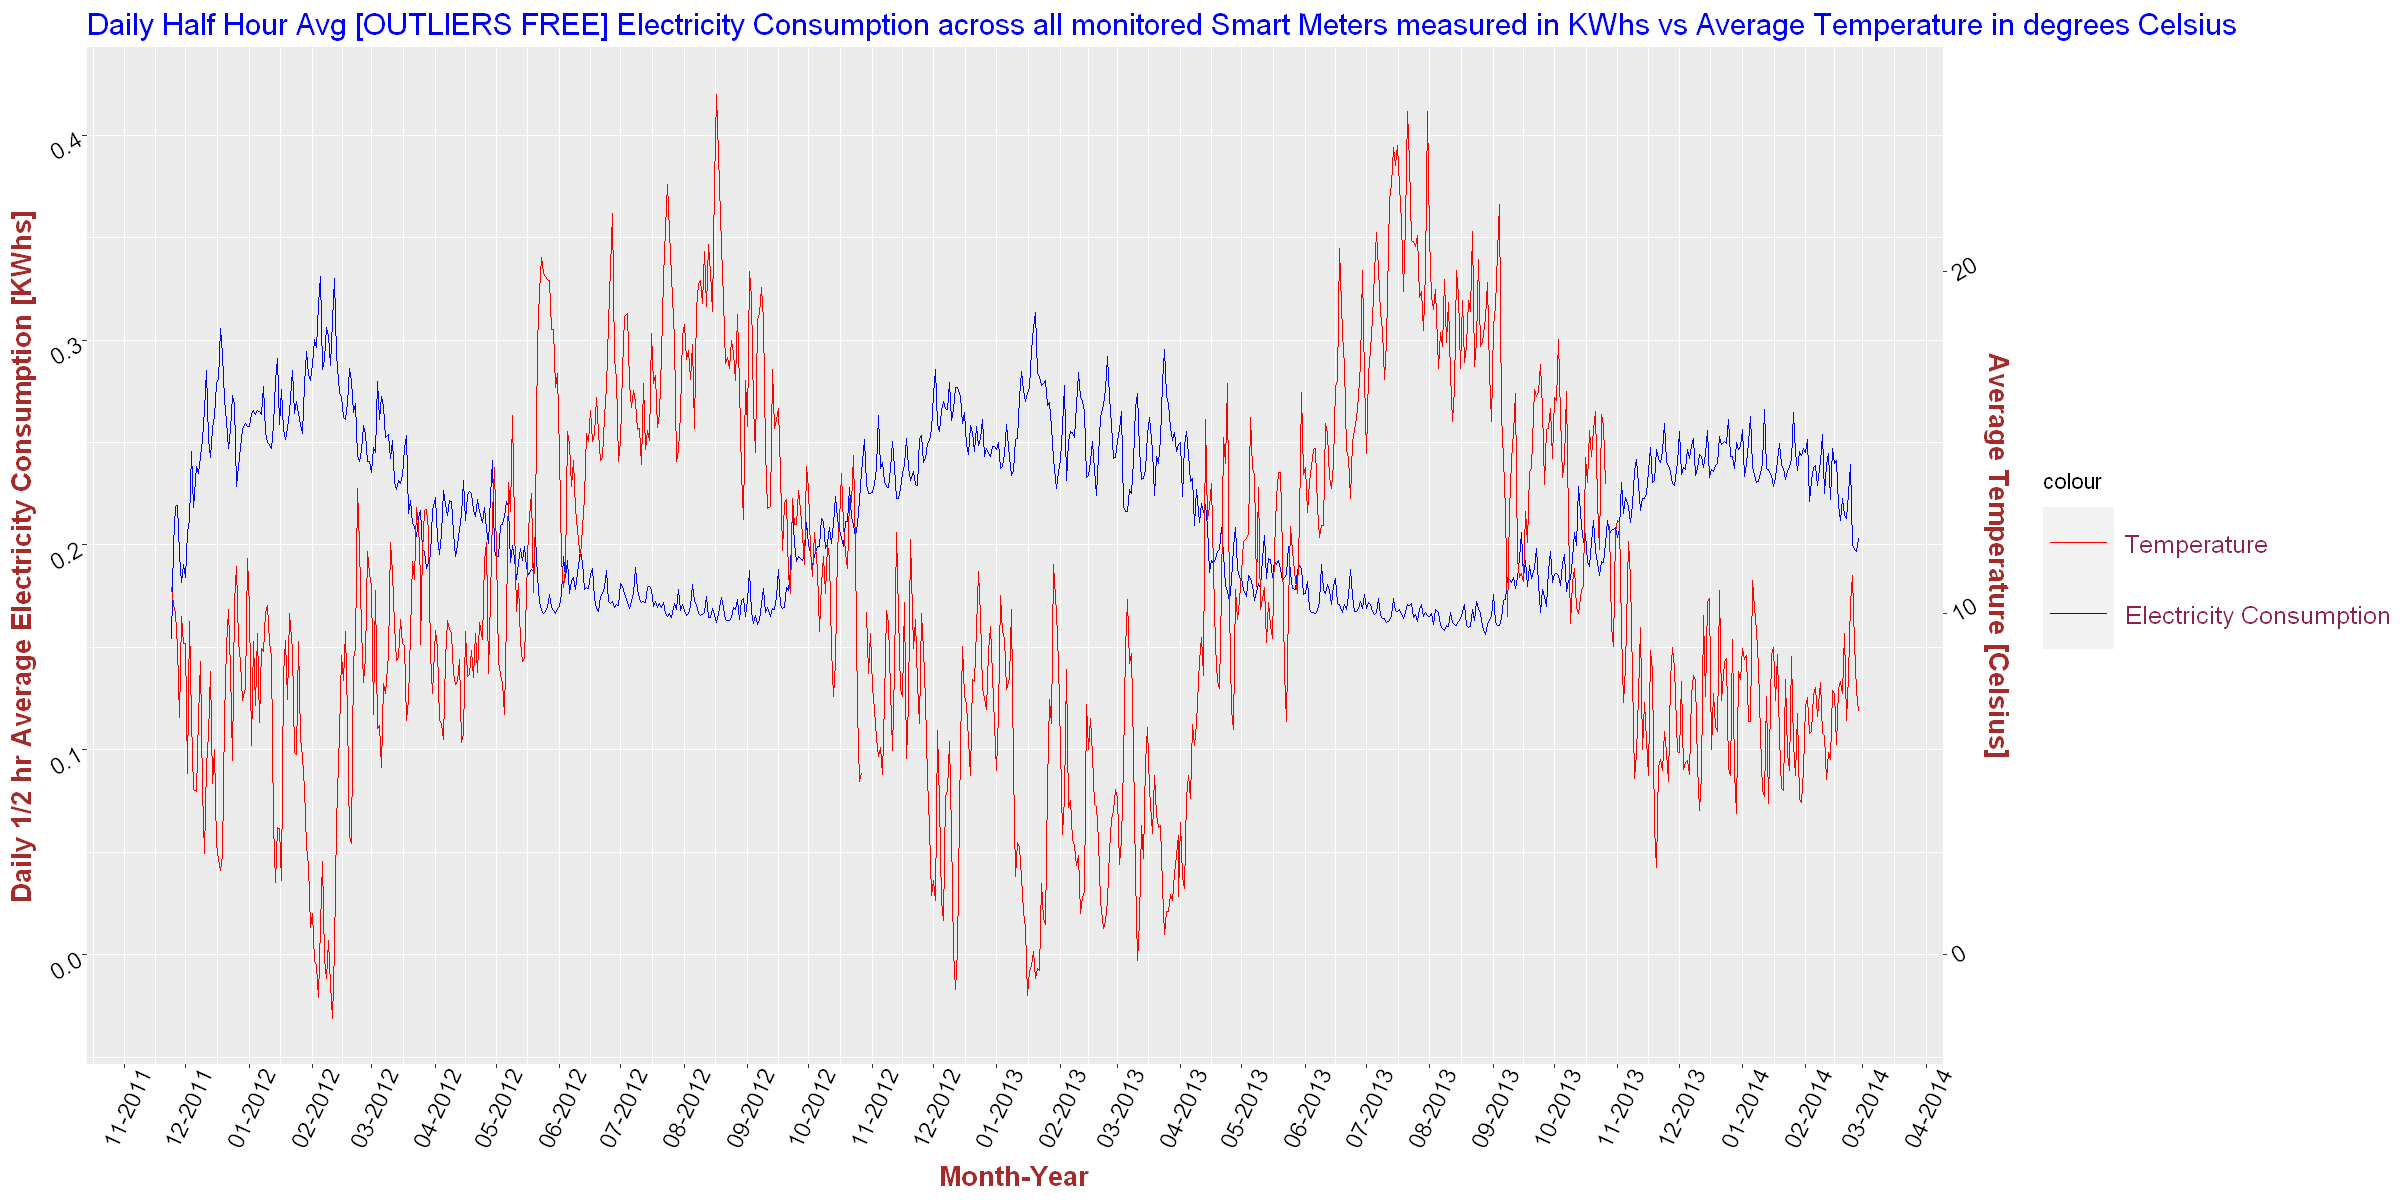

In [589]:
options(repr.plot.width = 20, repr.plot.height = 10)

ggplot()+   
  geom_line(data=weathDailyhhblocks, aes(x=timeDate,y=outlierLessAvg,col="Consumption"))+
  scale_y_continuous(sec.axis = sec_axis(~.*60, name = "Average Temperature [Celsius]"))+
  scale_x_date(date_breaks = "months" , date_labels = "%m-%Y")+
  geom_line(data=weathDailyhhblocks, aes(x=timeDate, y=((temperatureMin + temperatureMax)/2)/60, col=" Avg Temperature"))+
  scale_color_manual(values=c("red","blue"),
                     labels=c("Temperature","Electricity Consumption"))+
  labs(title = "Daily Half Hour Avg [OUTLIERS FREE] Electricity Consumption across all monitored Smart Meters measured in KWhs vs Average Temperature in degrees Celsius",
       x = "Month-Year",
       y = "Daily 1/2 hr Average Electricity Consumption [KWhs]") +
theme(axis.text.x = element_text(size=14, angle=65, vjust=0.6, color="black"), 
        axis.text.y = element_text(size=14, angle=30, vjust=0.6, color="black"),
        axis.title=element_text(size=16, face="bold", color="brown"),
        plot.caption = element_text(color= "red", size=14, angle=0, vjust=0.6),
        plot.title = element_text(color= "blue", size=18, angle=0, vjust=0.6),
        plot.subtitle = element_text(color= "blue", size=14, angle=0, vjust=0.6, face="italic"),
        legend.title = element_text(size = 13), legend.text = element_text(color = "violetred4", size = 15), 
        legend.key.size = unit(1.5, "cm"), legend.key.width = unit(1.5,"cm")) 

#### Loads data for daily Average Energy Consumption and Min, Max Temperatures [from all Smart Meters for the entire time period]

In [590]:
enrgConsvsTemp <- dbGetQuery(dbConn, 
"
select cast(dd.day as date) as day, cast(dd.all_meter_day_energy_mean as decimal(6,4)) as all_meter_day_energy_mean, wdd.temperatureMin, wdd.temperatureMax 
FROM 
(
select day, sum(energy_sum) / sum(energy_count) as all_meter_day_energy_mean
from daily_dataset
group by day
) dd
left outer join
weather_daily_darksky wdd
on substring(dd.day, 1, locate(' ', dd.day)) = substring(wdd.time, 1, locate(' ', wdd.time)) 
order by day
;
"
)

In [591]:
head(enrgConsvsTemp)

,day,all_meter_day_energy_mean,temperatureMin,temperatureMax
,<date>,<dbl>,<dbl>,<dbl>
1,2011-11-23,0.2706,3.81,10.36
2,2011-11-24,0.2315,8.56,12.93
3,2011-11-25,0.2198,7.46,13.03
4,2011-11-26,0.2374,7.01,12.96
5,2011-11-27,0.2261,4.47,13.54
6,2011-11-28,0.2159,1.31,12.58


#### Plots the Daily Avg Energy Consumption and Average Temperature vs Time, across all Smart Meters

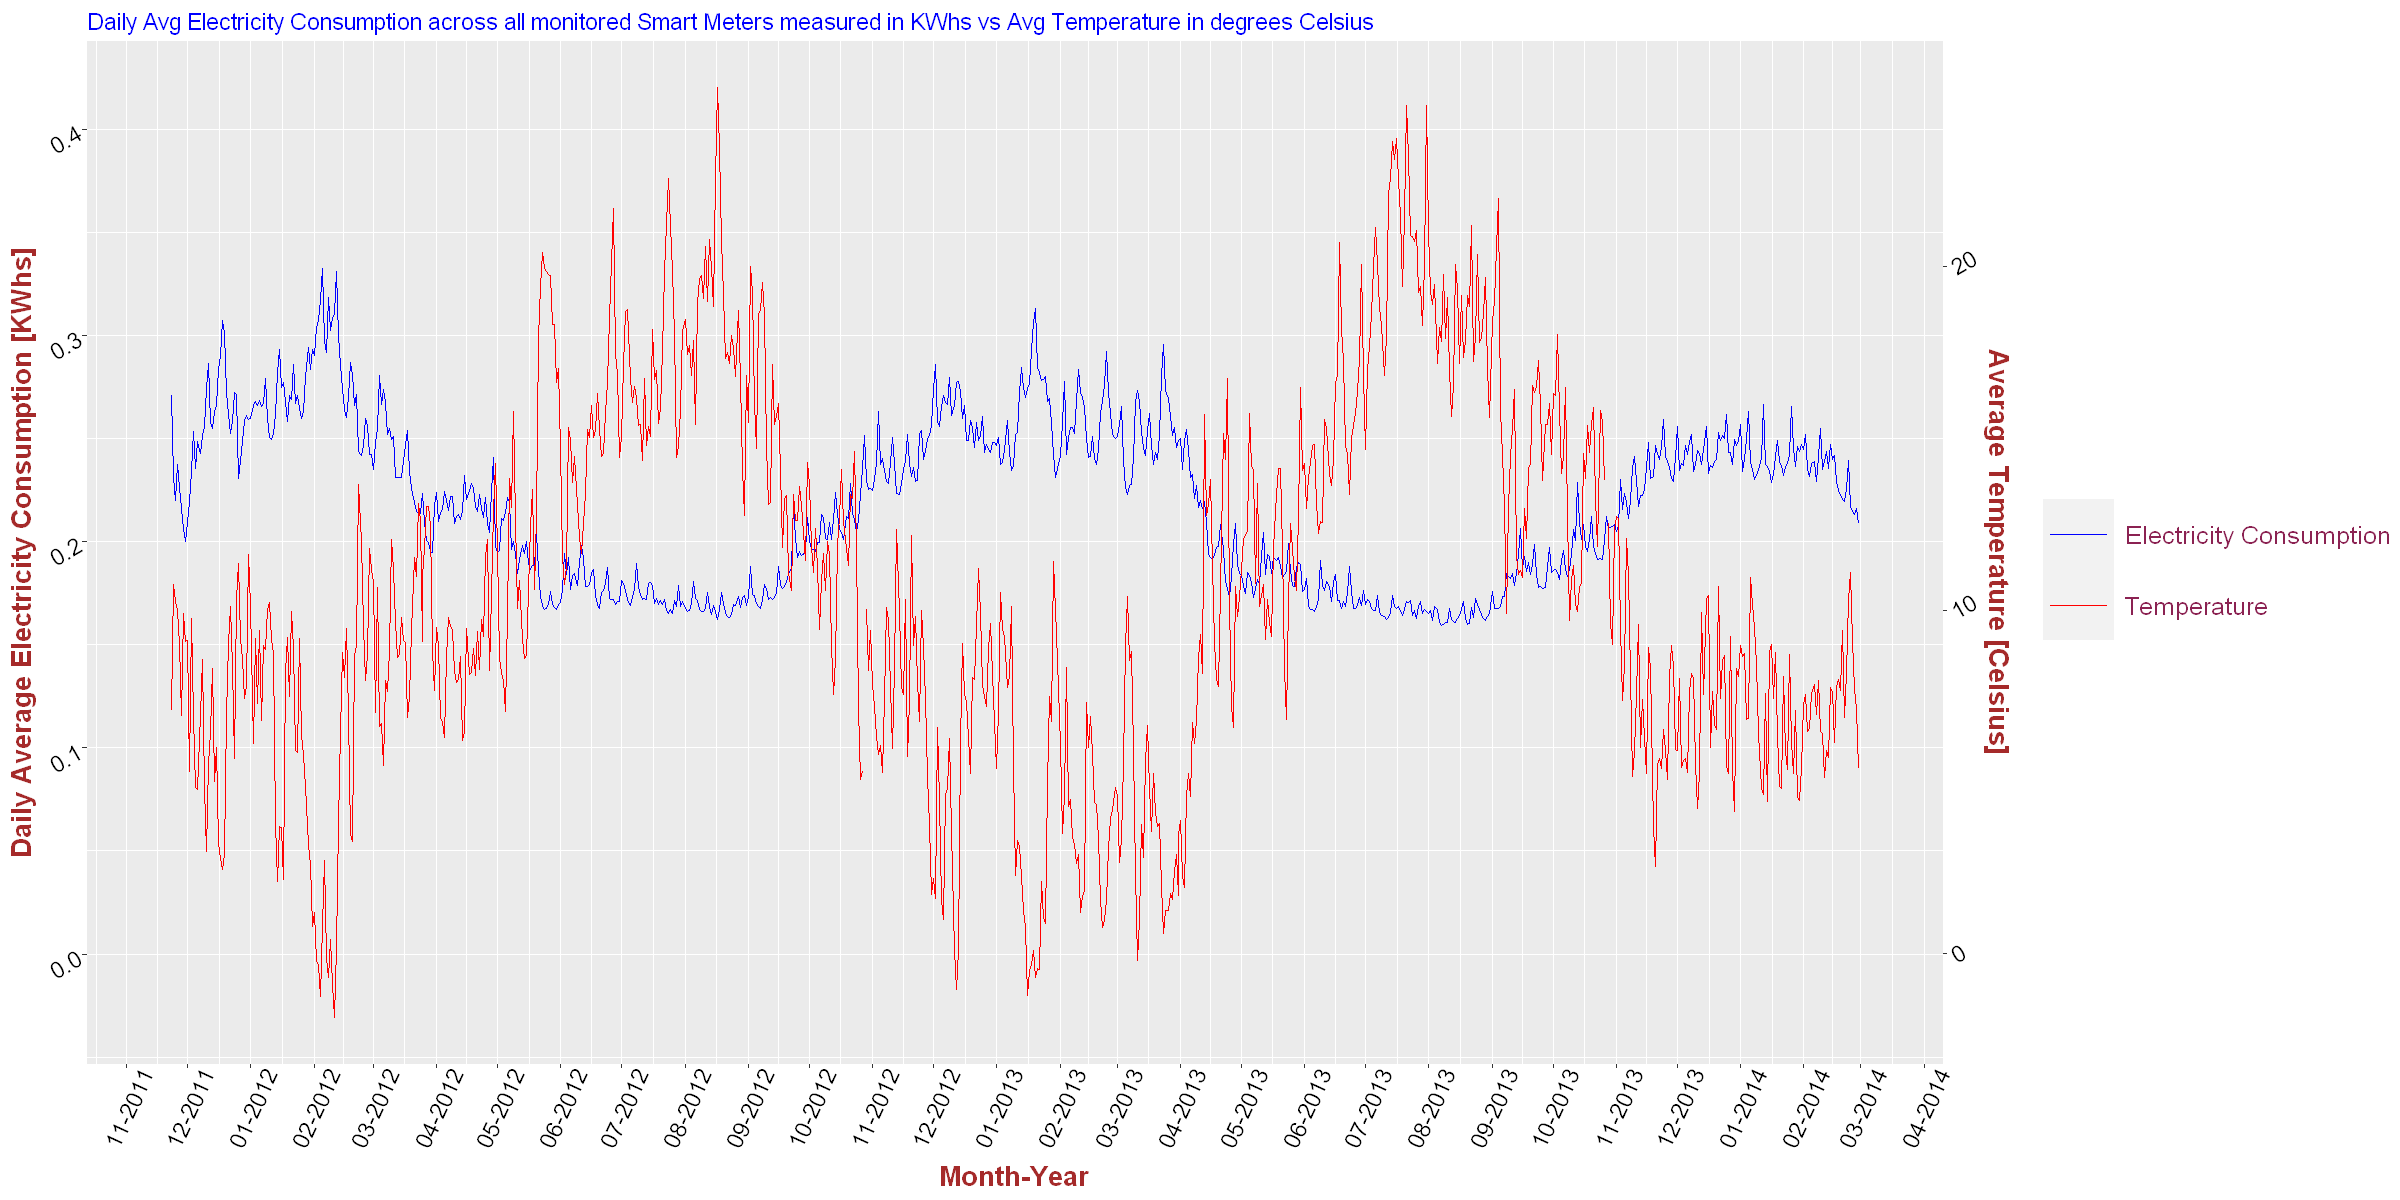

In [592]:
options(repr.plot.width = 20, repr.plot.height = 10)

ggplot()+   
  geom_line(data=enrgConsvsTemp, aes(x=day,y=all_meter_day_energy_mean,col="Consumption"))+
  scale_y_continuous(sec.axis = sec_axis(~.*60, name = "Average Temperature [Celsius]"))+
  scale_x_date(date_breaks = "months" , date_labels = "%m-%Y")+
  geom_line(data=enrgConsvsTemp, aes(x=day, y=(temperatureMin + temperatureMax)/2/60, col="Temperature"))+
  scale_color_manual("",values=c("blue","red"),
                     labels=c("Electricity Consumption","Temperature"))+
  labs(title = "Daily Avg Electricity Consumption across all monitored Smart Meters measured in KWhs vs Avg Temperature in degrees Celsius",
       x = "Month-Year",
       y = "Daily Average Electricity Consumption [KWhs]") +
theme(axis.text.x = element_text(size=14, angle=65, vjust=0.6, color="black"), 
        axis.text.y = element_text(size=14, angle=30, vjust=0.6, color="black"),
        axis.title=element_text(size=16, face="bold", color="brown"),
        plot.caption = element_text(color= "red", size=14, angle=0, vjust=0.6),
        plot.title = element_text(color= "blue", size=14, angle=0, vjust=0.6),
        plot.subtitle = element_text(color= "blue", size=14, angle=0, vjust=0.6, face="italic"),
        legend.title = element_text(size = 13), legend.text = element_text(color = "violetred4", size = 15), 
        legend.key.size = unit(1.5, "cm"), legend.key.width = unit(1.5,"cm")) 

#### Loads data for daily Avg Energy Consumption for all reported ACORN groups

In [593]:
acornEnrgCons <- dbGetQuery(dbConn, 
"
select cast(day as date) as day, Acorn_grouped, sum(energy_sum) / sum(energy_count) as all_meter_day_energy_mean
FROM 
(
SELECT dd.LCLid , dd.day, ih.Acorn_grouped, energy_sum , energy_count 
FROM daily_dataset dd 
left outer join
informations_households ih
on ih.LCLid = dd.LCLid 
) hih 
group by day, Acorn_grouped
;
"
)

#### Plots Average Daily Consumption vs Time per ACORN group

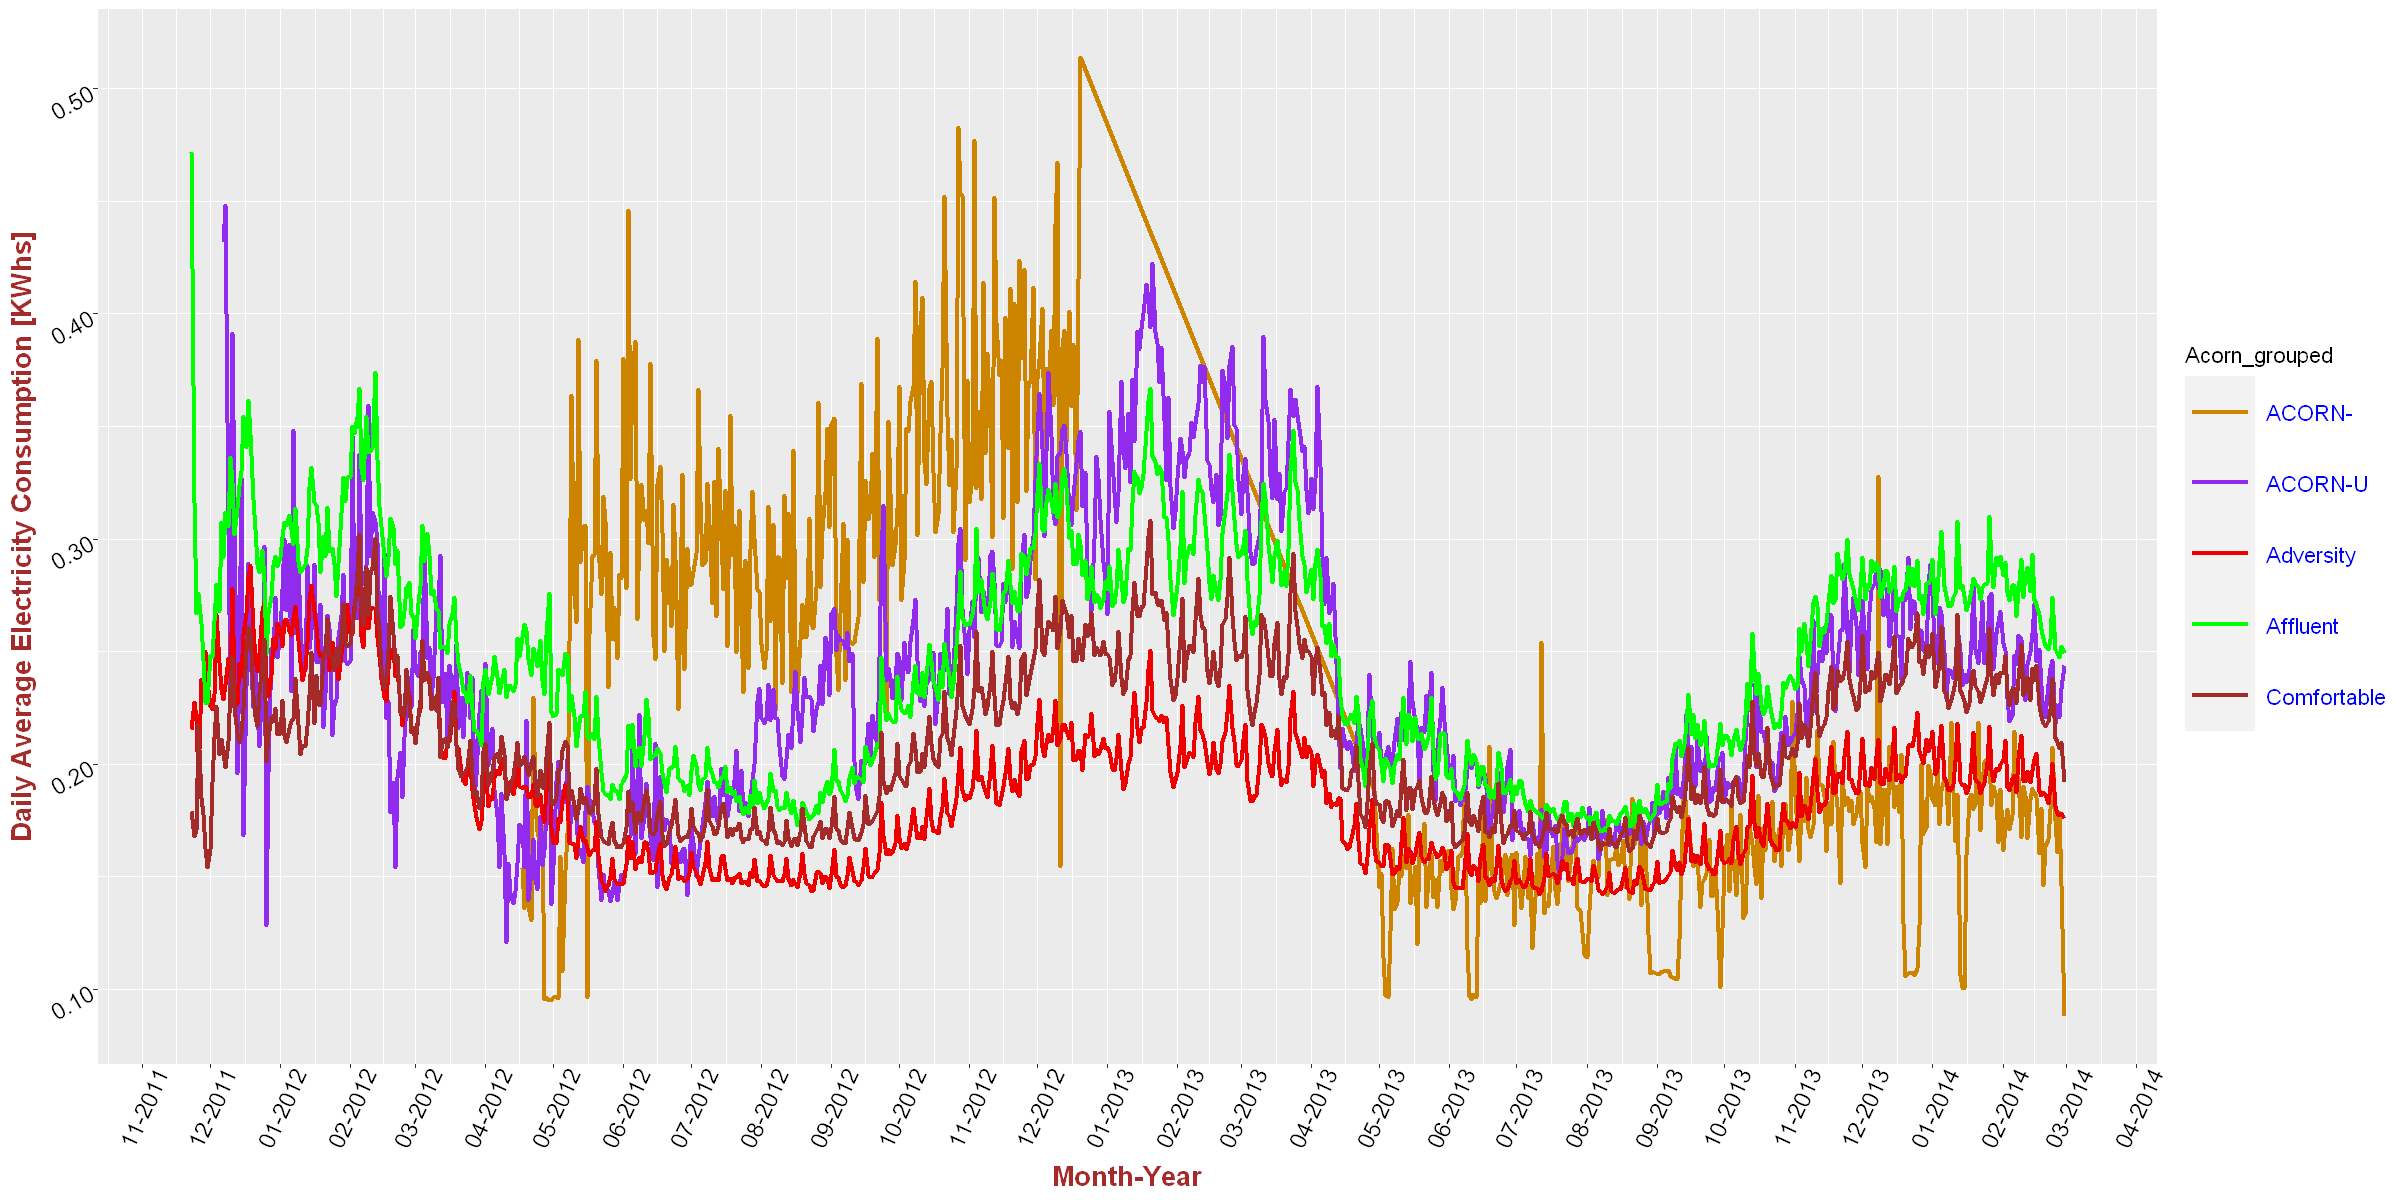

In [594]:
ggplot(acornEnrgCons, aes(x = day, y = all_meter_day_energy_mean)) + 
  geom_line(aes(color = Acorn_grouped), size=1.2, linetype = "solid") +
  scale_color_manual(values = c("orange3", "purple2", "red2", "green", "brown")) +
  labs(x='Month-Year', y='Daily Average Electricity Consumption [KWhs]') +
 theme(axis.text.x = element_text(size=14, angle=65, vjust=0.6, color="black"), 
        axis.text.y = element_text(size=14, angle=30, vjust=0.6, color="black"),
        axis.title=element_text(size=16, face="bold", color="brown"),
        plot.caption = element_text(color= "red", size=14, angle=0, vjust=0.6),
        plot.title = element_text(color= "blue", size=14, angle=0, vjust=0.6),
        plot.subtitle = element_text(color= "blue", size=14, angle=0, vjust=0.6, face="italic"),
        legend.title = element_text(size = 13), legend.text = element_text(color = "blue", size = 13), 
        legend.key.size = unit(1.5, "cm"), legend.key.width = unit(1.5,"cm")) +
  scale_y_continuous(labels = scales::comma_format(big.mark = ',', decimal.mark = '.')) +
scale_x_date(date_breaks = "months" , date_labels = "%m-%Y")

#### Loads data for daily Avg Energy Consumption for participant groups [Std: standard, ToU time of use] where ToU (Std) were those who were (not) notified when a tariff changed in a day 

In [595]:
ctrlExpEnrgCons <- dbGetQuery(dbConn, 
"
select cast(day as date) as day, stdorToU, sum(energy_sum) / sum(energy_count) as all_meter_day_energy_mean
FROM 
(
SELECT dd.LCLid , dd.day, ih.stdorToU, energy_sum , energy_count 
FROM daily_dataset dd 
left outer join
informations_households ih
on ih.LCLid = dd.LCLid 
) hih 
group by day, stdorToU 
;
"
)

#### Plots Average Daily Consumption vs Time by fluctuating tariff aware group

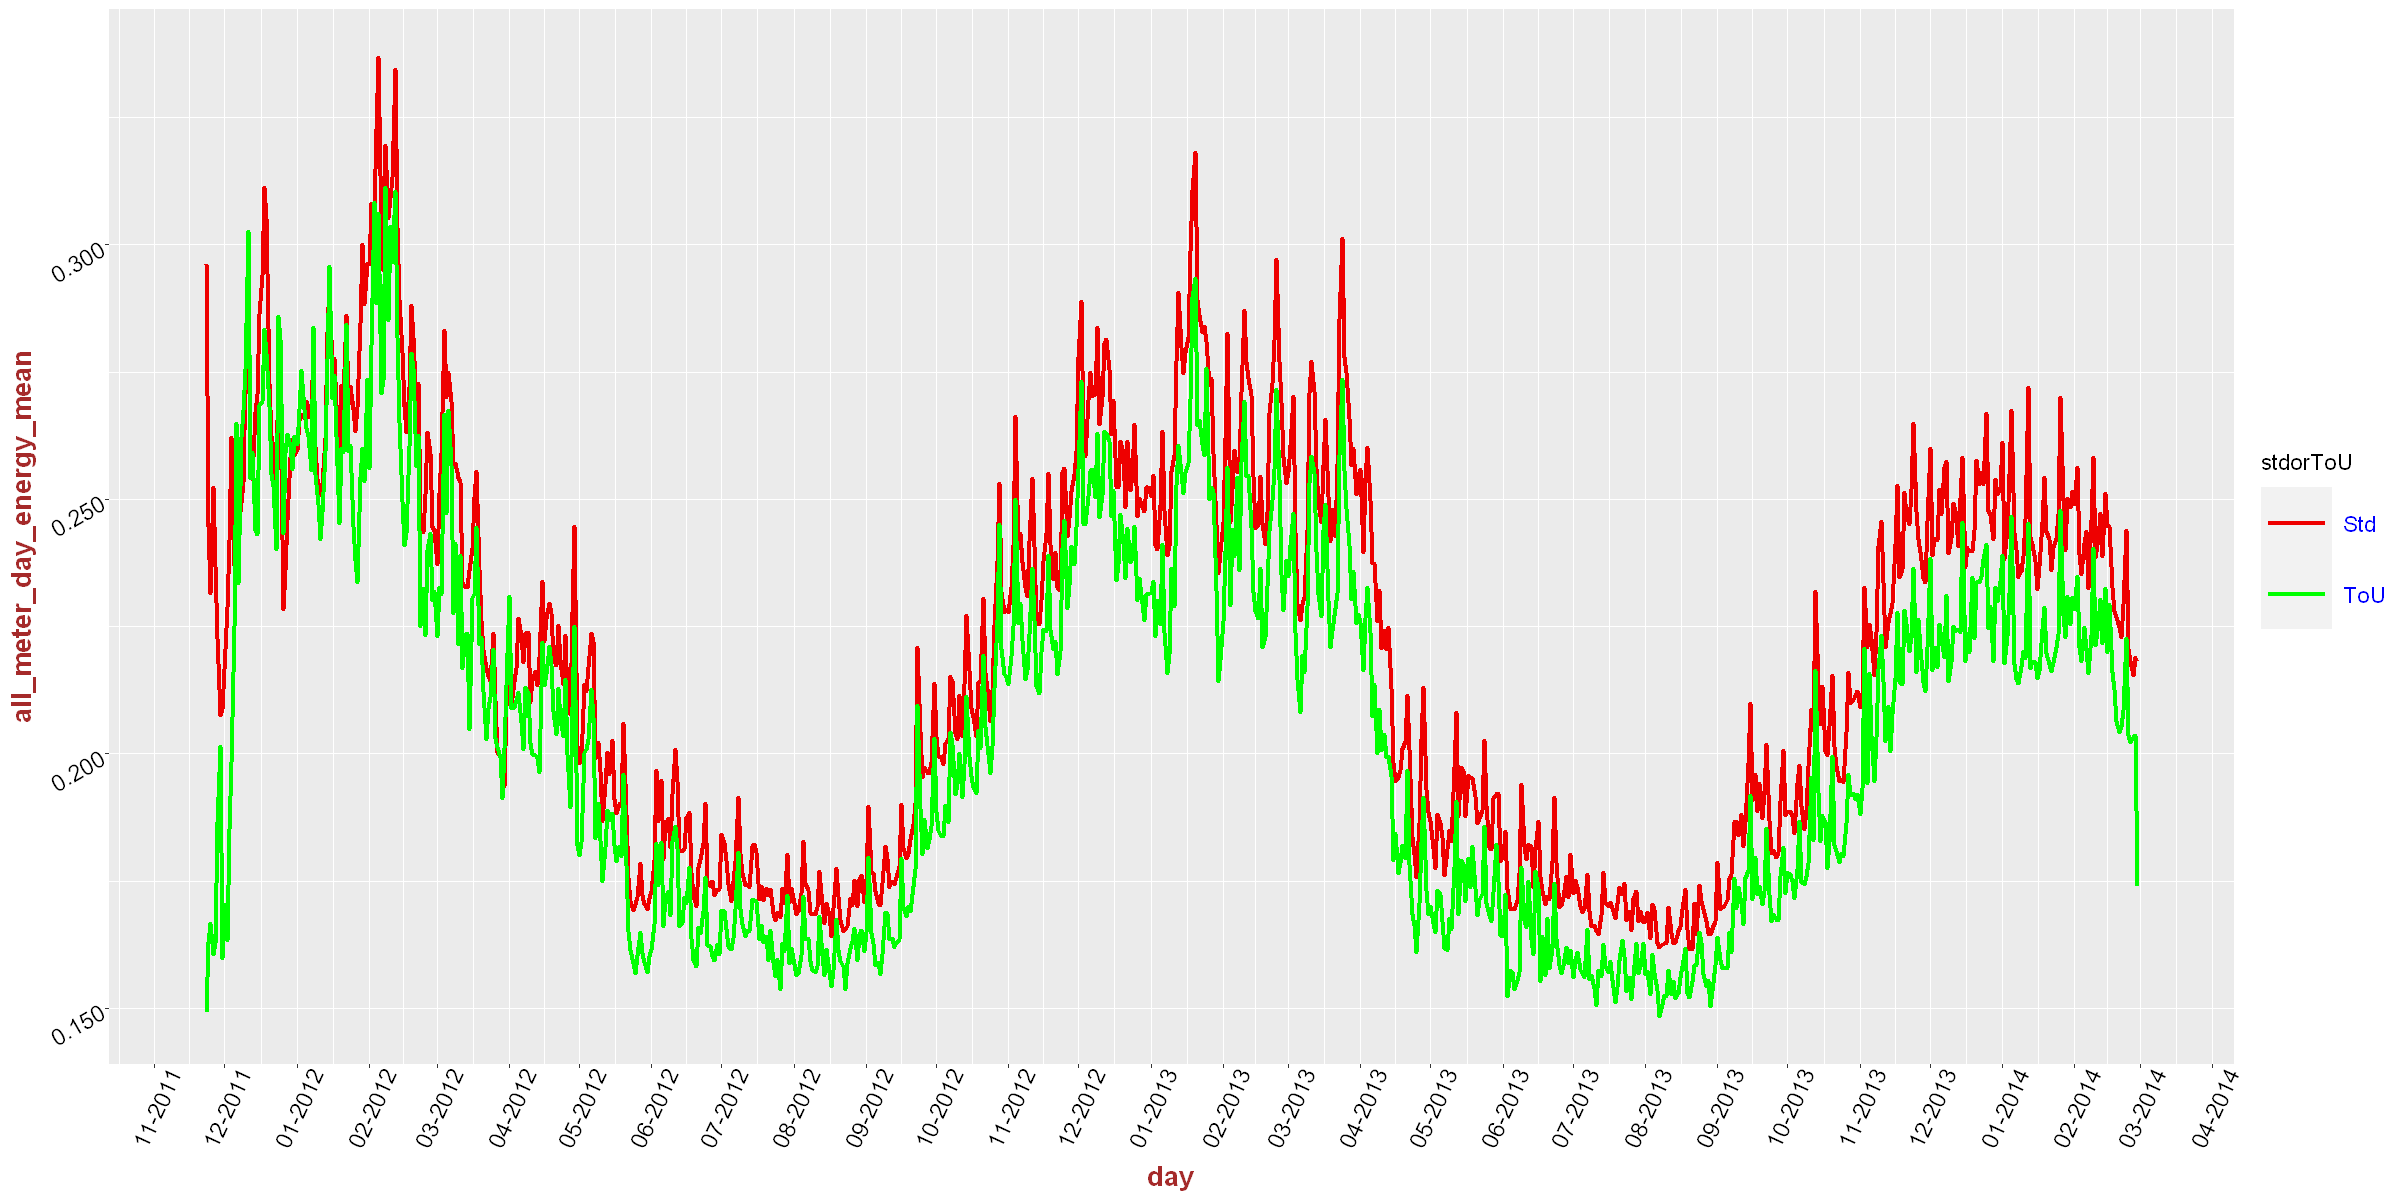

In [596]:
ggplot(ctrlExpEnrgCons, aes(x = day, y = all_meter_day_energy_mean)) + 
  geom_line(aes(color = stdorToU), size=1.2, linetype = "solid") +
  scale_color_manual(values = c("red2", "green")) +
  labs(x='day', y='all_meter_day_energy_mean') +
 theme(axis.text.x = element_text(size=14, angle=65, vjust=0.6, color="black"), 
        axis.text.y = element_text(size=14, angle=30, vjust=0.6, color="black"),
        axis.title=element_text(size=16, face="bold", color="brown"),
        plot.caption = element_text(color= "red", size=14, angle=0, vjust=0.6),
        plot.title = element_text(color= "blue", size=14, angle=0, vjust=0.6),
        plot.subtitle = element_text(color= "blue", size=14, angle=0, vjust=0.6, face="italic"),
        legend.title = element_text(size = 13), legend.text = element_text(color = "blue", size = 13), 
        legend.key.size = unit(1.5, "cm"), legend.key.width = unit(1.5,"cm")) +
  scale_y_continuous(labels = scales::comma_format(big.mark = ',', decimal.mark = '.')) +
scale_x_date(date_breaks = "months" , date_labels = "%m-%Y")

#### Builds a correlation coefficient matrix of Energy Consumption, Temperature and Humidity.  

In [646]:
weathEnrgCons <- dbGetQuery(dbConn, 
"
select Avg_Energy_Consump,  temperature, humidity
from daily_dataset_hhblocks_byHour a
left outer join
weather_hourly_darksky b
on a.`day` = b.`time`
;
"
)

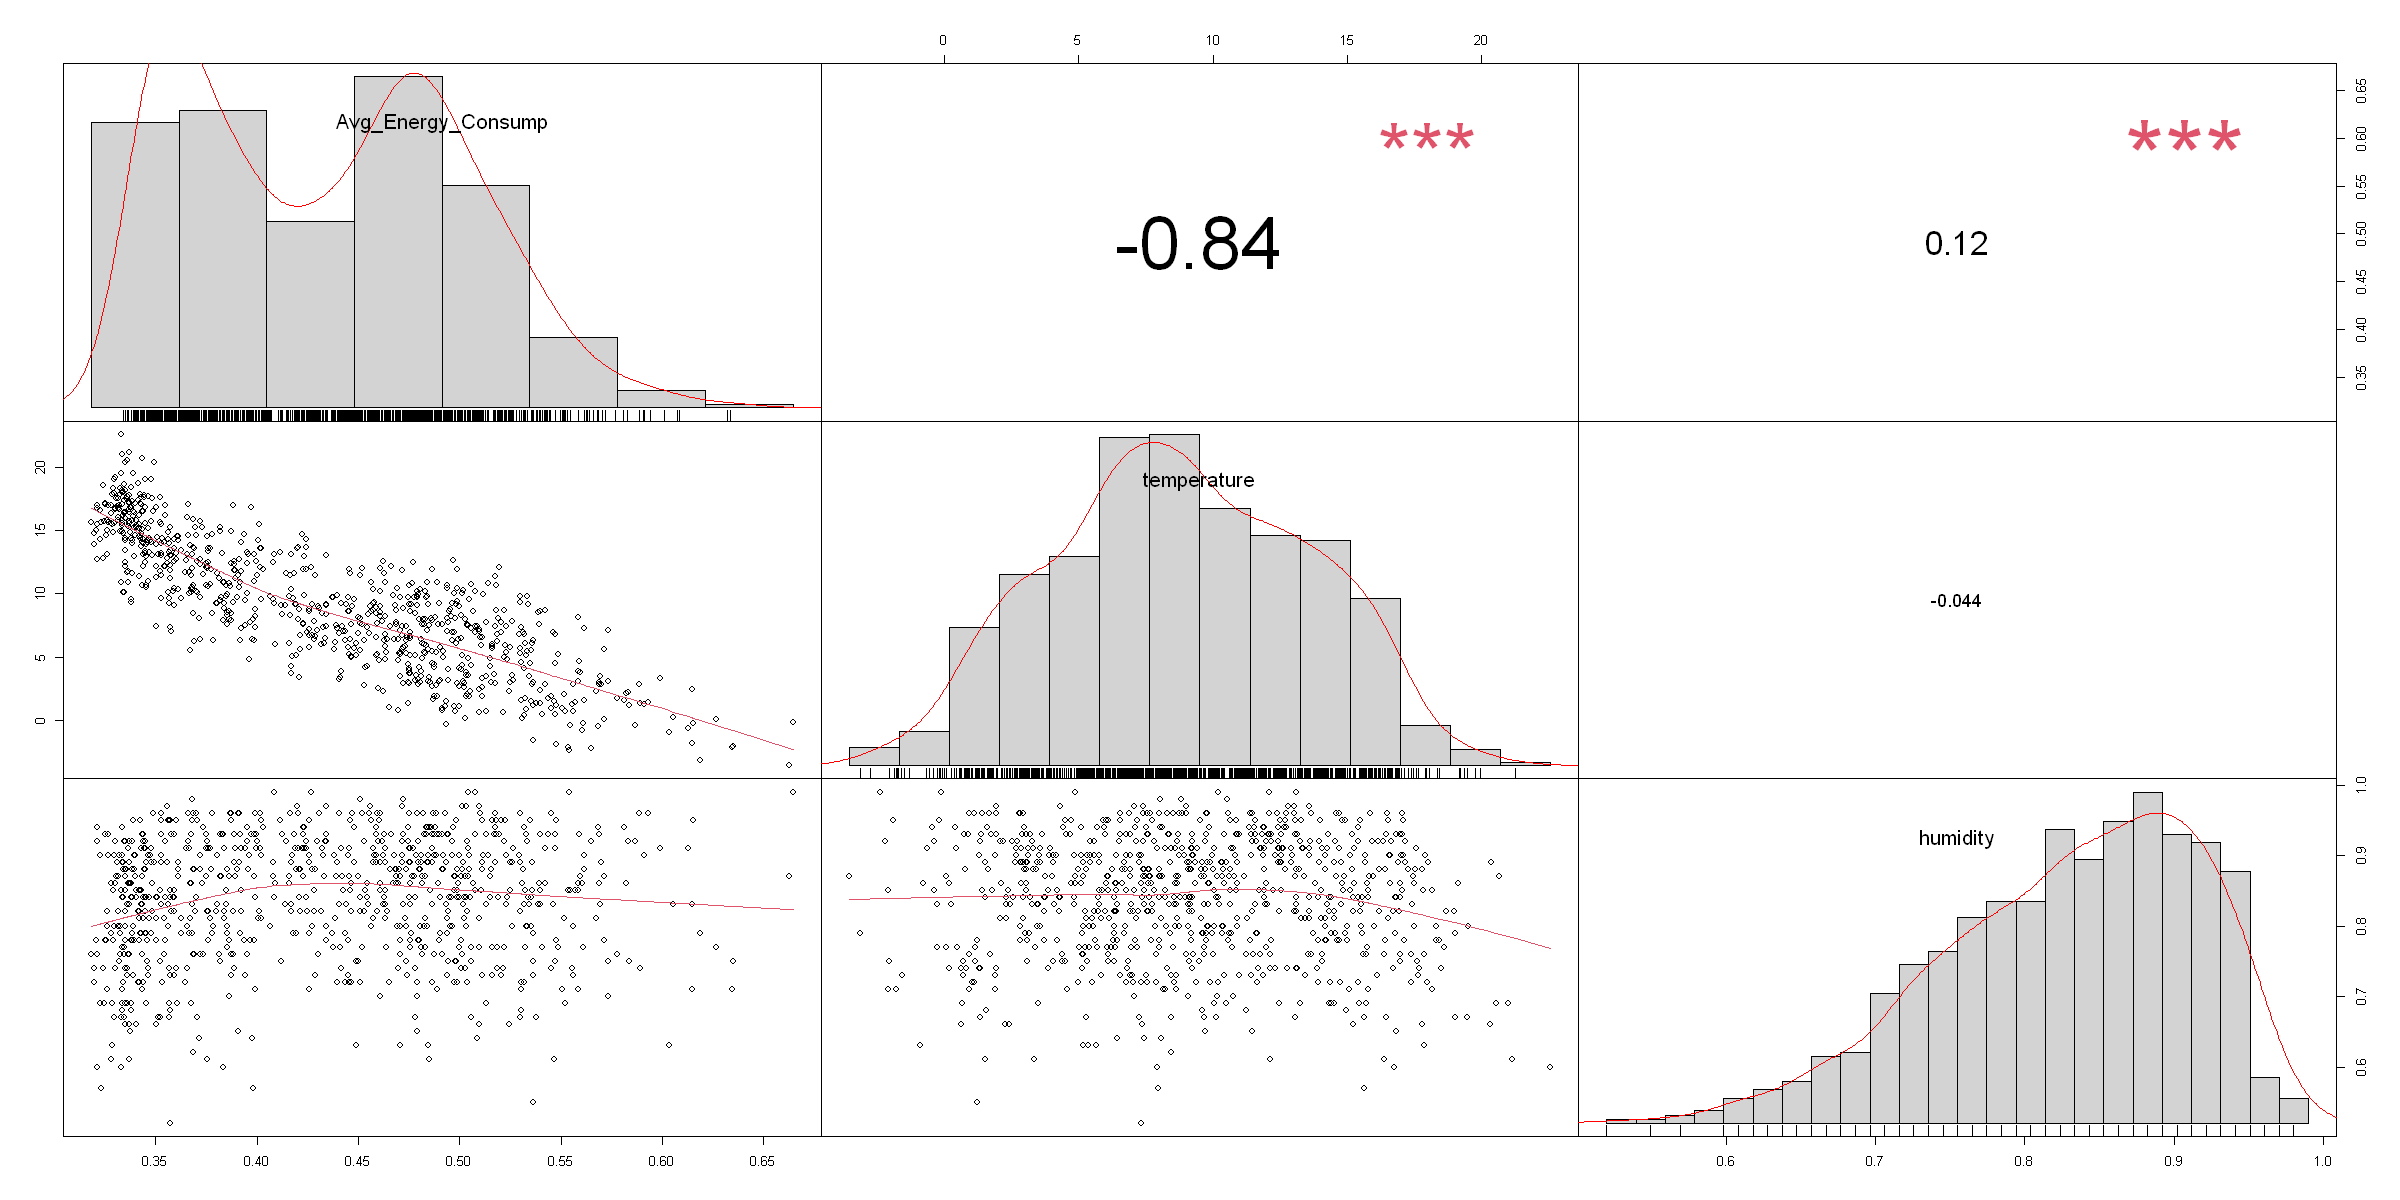

In [647]:
chart.Correlation(weathEnrgCons, histogram=TRUE, method="pearson", pch=19)

#### Loads temperature, humidity, precipType and time from Daily Weather data set 

In [597]:
weathHourly <- dbGetQuery(dbConn, 
"
select time, temperature, humidity, precipType 
from weather_hourly_darksky
;
"
)

#### Splits the 'time' column in date and time and data frames it with humidity

In [598]:
weathHourly <- weathHourly %>% mutate(time = str_replace(time, " ", "|")) %>% separate(time, into = c("timeDate", "timeTime"), sep = "\\|")
weathHourly$timeDate <- trim(weathHourly$timeDate)
weathHourly$timeTime <- trim(weathHourly$timeTime)
weathHourly$humidity <- 100*(weathHourly$humidity)

In [599]:
head(weathHourly)

,timeDate,timeTime,temperature,humidity,precipType
,<chr>,<chr>,<dbl>,<dbl>,<chr>
1,2011-11-11,00:00:00,10.24,91,rain
2,2011-11-11,01:00:00,9.76,94,rain
3,2011-11-11,02:00:00,9.46,96,rain
4,2011-11-11,03:00:00,9.23,96,rain
5,2011-11-11,04:00:00,9.26,100,rain
6,2011-11-11,05:00:00,9.33,97,rain


#### Plots temperature vs time constructs in a multi-month color coded matrix

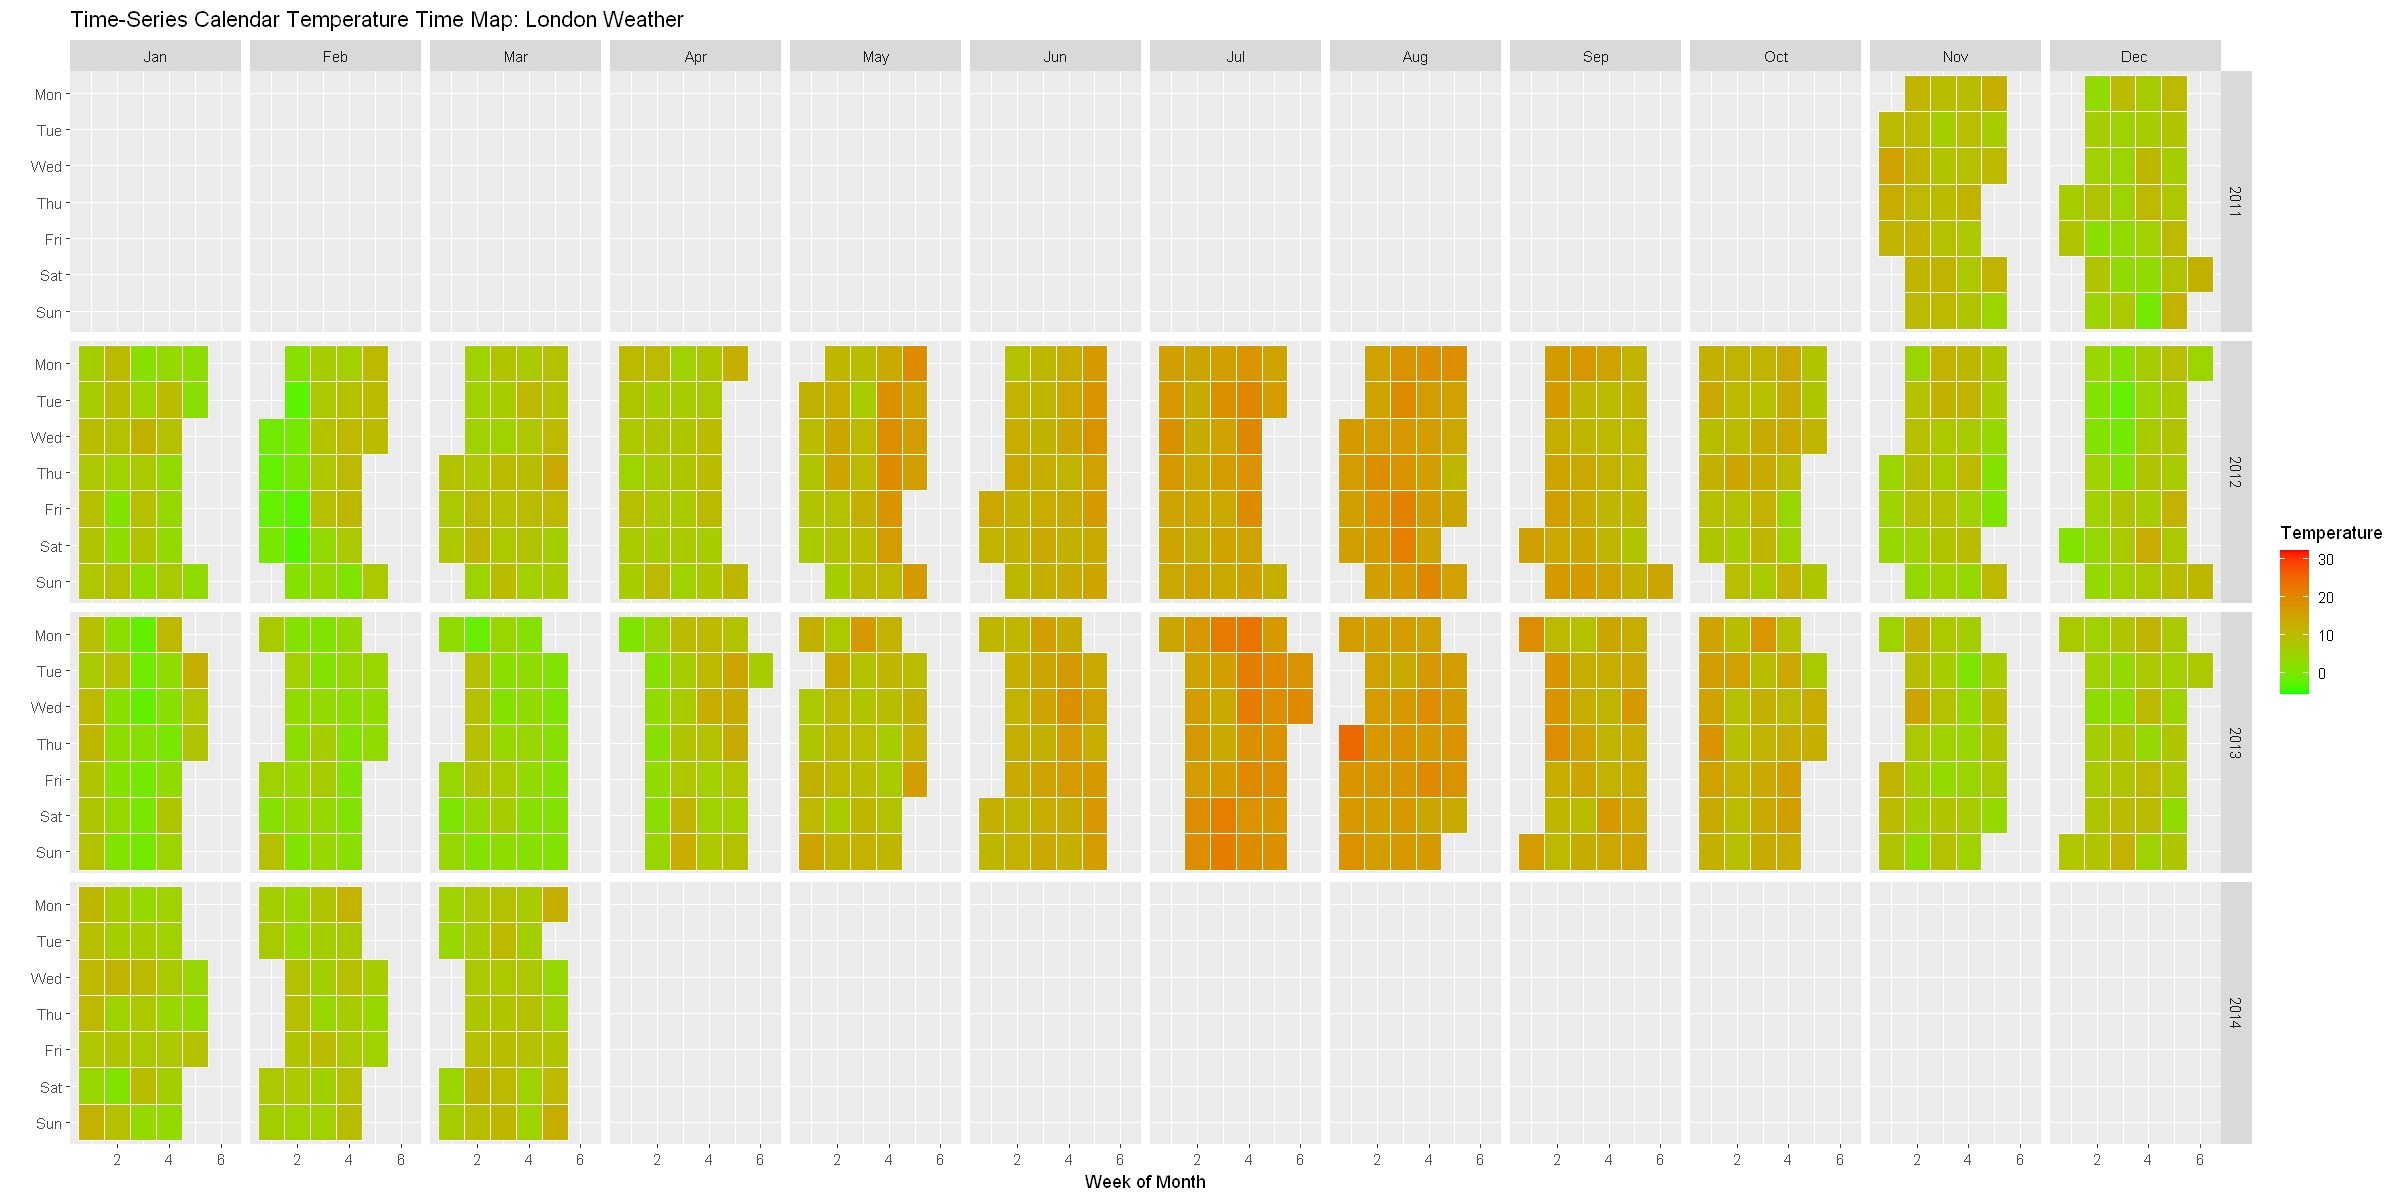

In [600]:
vars <- c("timeDate", "timeTime", "temperature")
htMapTimeTemp <- weathHourly[vars]

htMapTimeTemp$weekday = as.POSIXlt(htMapTimeTemp$timeDate)$wday #finding the day numb of the week
htMapTimeTemp$weekdayf<-factor(htMapTimeTemp$weekday,levels=rev(1:7),labels=rev(c("Mon","Tue","Wed","Thu","Fri","Sat","Sun")),ordered=TRUE) #converting the day numb to factor 
htMapTimeTemp$weekdayf[is.na(htMapTimeTemp$weekdayf)] <- "Sun"
htMapTimeTemp$monthf<-factor(month(htMapTimeTemp$timeDate),levels=as.character(1:12),labels=c("Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"),ordered=TRUE) # finding the month 
htMapTimeTemp$yearmonth<- factor(as.yearmon(htMapTimeTemp$timeDate)) #finding the year and the month from the date. Eg: Nov 2012 
htMapTimeTemp$week <- as.numeric(week(htMapTimeTemp$timeDate)) #finding the week of the year for each date 
htMapTimeTemp<-ddply(htMapTimeTemp,.(yearmonth),transform,monthweek=1+week-min(week)) #normalizing the week to start at 1 for every month 

ggplot(htMapTimeTemp, aes(monthweek, weekdayf, fill = temperature)) + 
geom_tile(colour = "white") + 
facet_grid(year(htMapTimeTemp$timeDate)~monthf) + 
scale_fill_gradient(low="green", high="red") + 
xlab("Week of Month") + ylab("") + 
ggtitle("Time-Series Calendar Temperature Time Map: London Weather") + 
labs(fill = "Temperature") 

#### Plots humidity vs time constructs in a multi-month color coded matrix

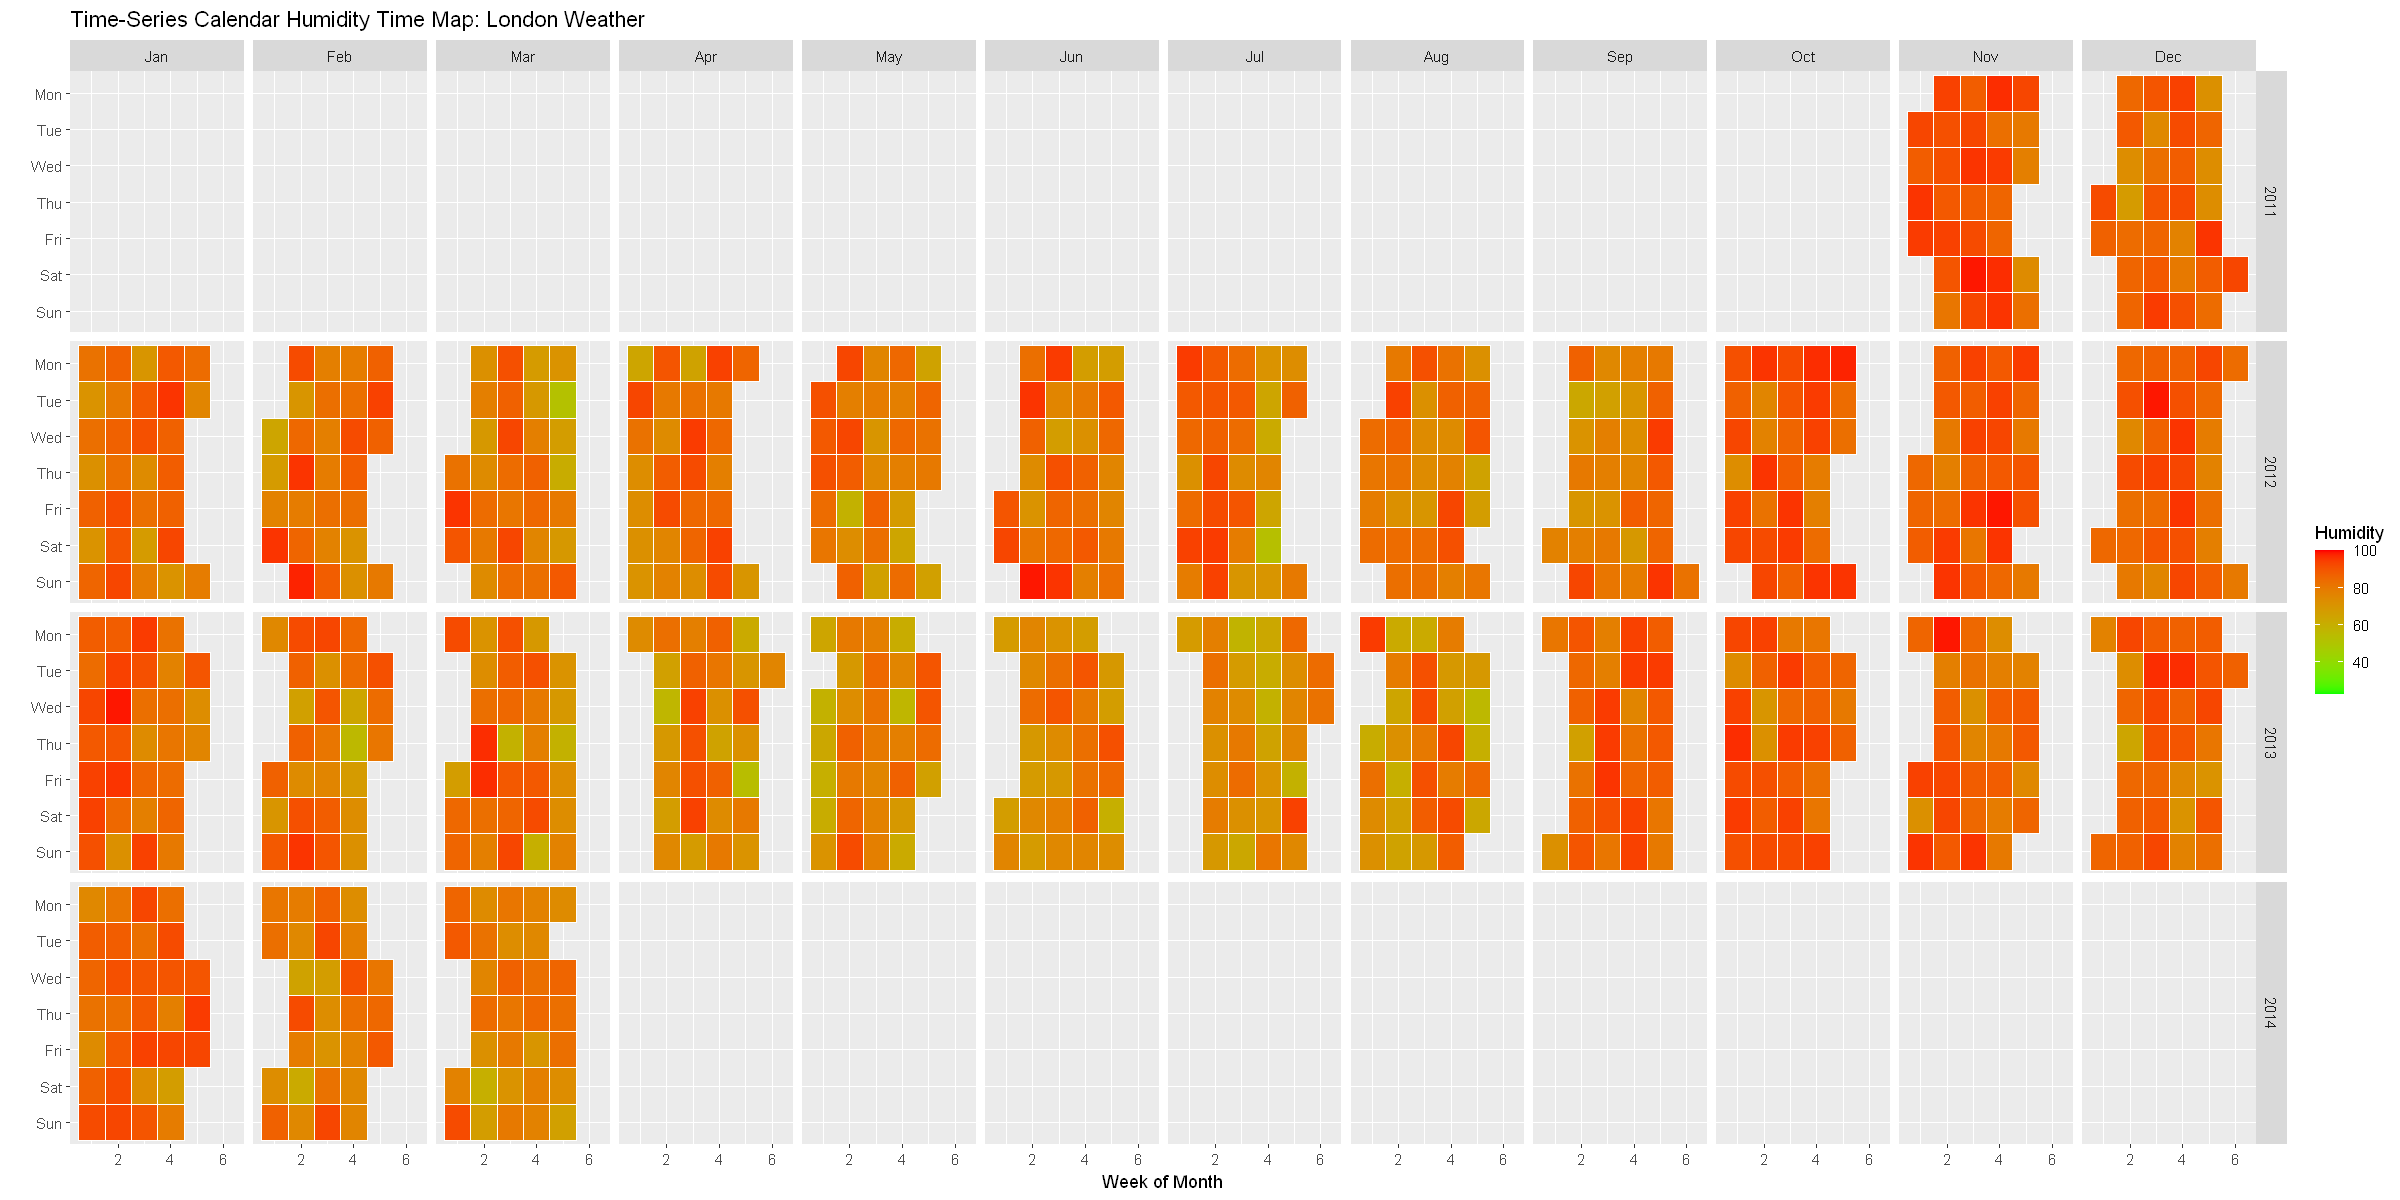

In [601]:
vars <- c("timeDate", "timeTime", "humidity")
htMapTimeTemp <- weathHourly[vars]

htMapTimeTemp$weekday = as.POSIXlt(htMapTimeTemp$timeDate)$wday #finding the day numb of the week
htMapTimeTemp$weekdayf<-factor(htMapTimeTemp$weekday,levels=rev(1:7),labels=rev(c("Mon","Tue","Wed","Thu","Fri","Sat","Sun")),ordered=TRUE) #converting the day numb to factor 
htMapTimeTemp$weekdayf[is.na(htMapTimeTemp$weekdayf)] <- "Sun"
htMapTimeTemp$monthf<-factor(month(htMapTimeTemp$timeDate),levels=as.character(1:12),labels=c("Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"),ordered=TRUE) # finding the month 
htMapTimeTemp$yearmonth<- factor(as.yearmon(htMapTimeTemp$timeDate)) #finding the year and the month from the date. Eg: Nov 2012 
htMapTimeTemp$week <- as.numeric(week(htMapTimeTemp$timeDate)) #finding the week of the year for each date 
htMapTimeTemp<-ddply(htMapTimeTemp,.(yearmonth),transform,monthweek=1+week-min(week)) #normalizing the week to start at 1 for every month 

ggplot(htMapTimeTemp, aes(monthweek, weekdayf, fill = humidity)) + 
geom_tile(colour = "white") + 
facet_grid(year(htMapTimeTemp$timeDate)~monthf) + 
scale_fill_gradient(low="green", high="red") + 
xlab("Week of Month") + ylab("") + 
ggtitle("Time-Series Calendar Humidity Time Map: London Weather") + 
labs(fill = "Humidity") 

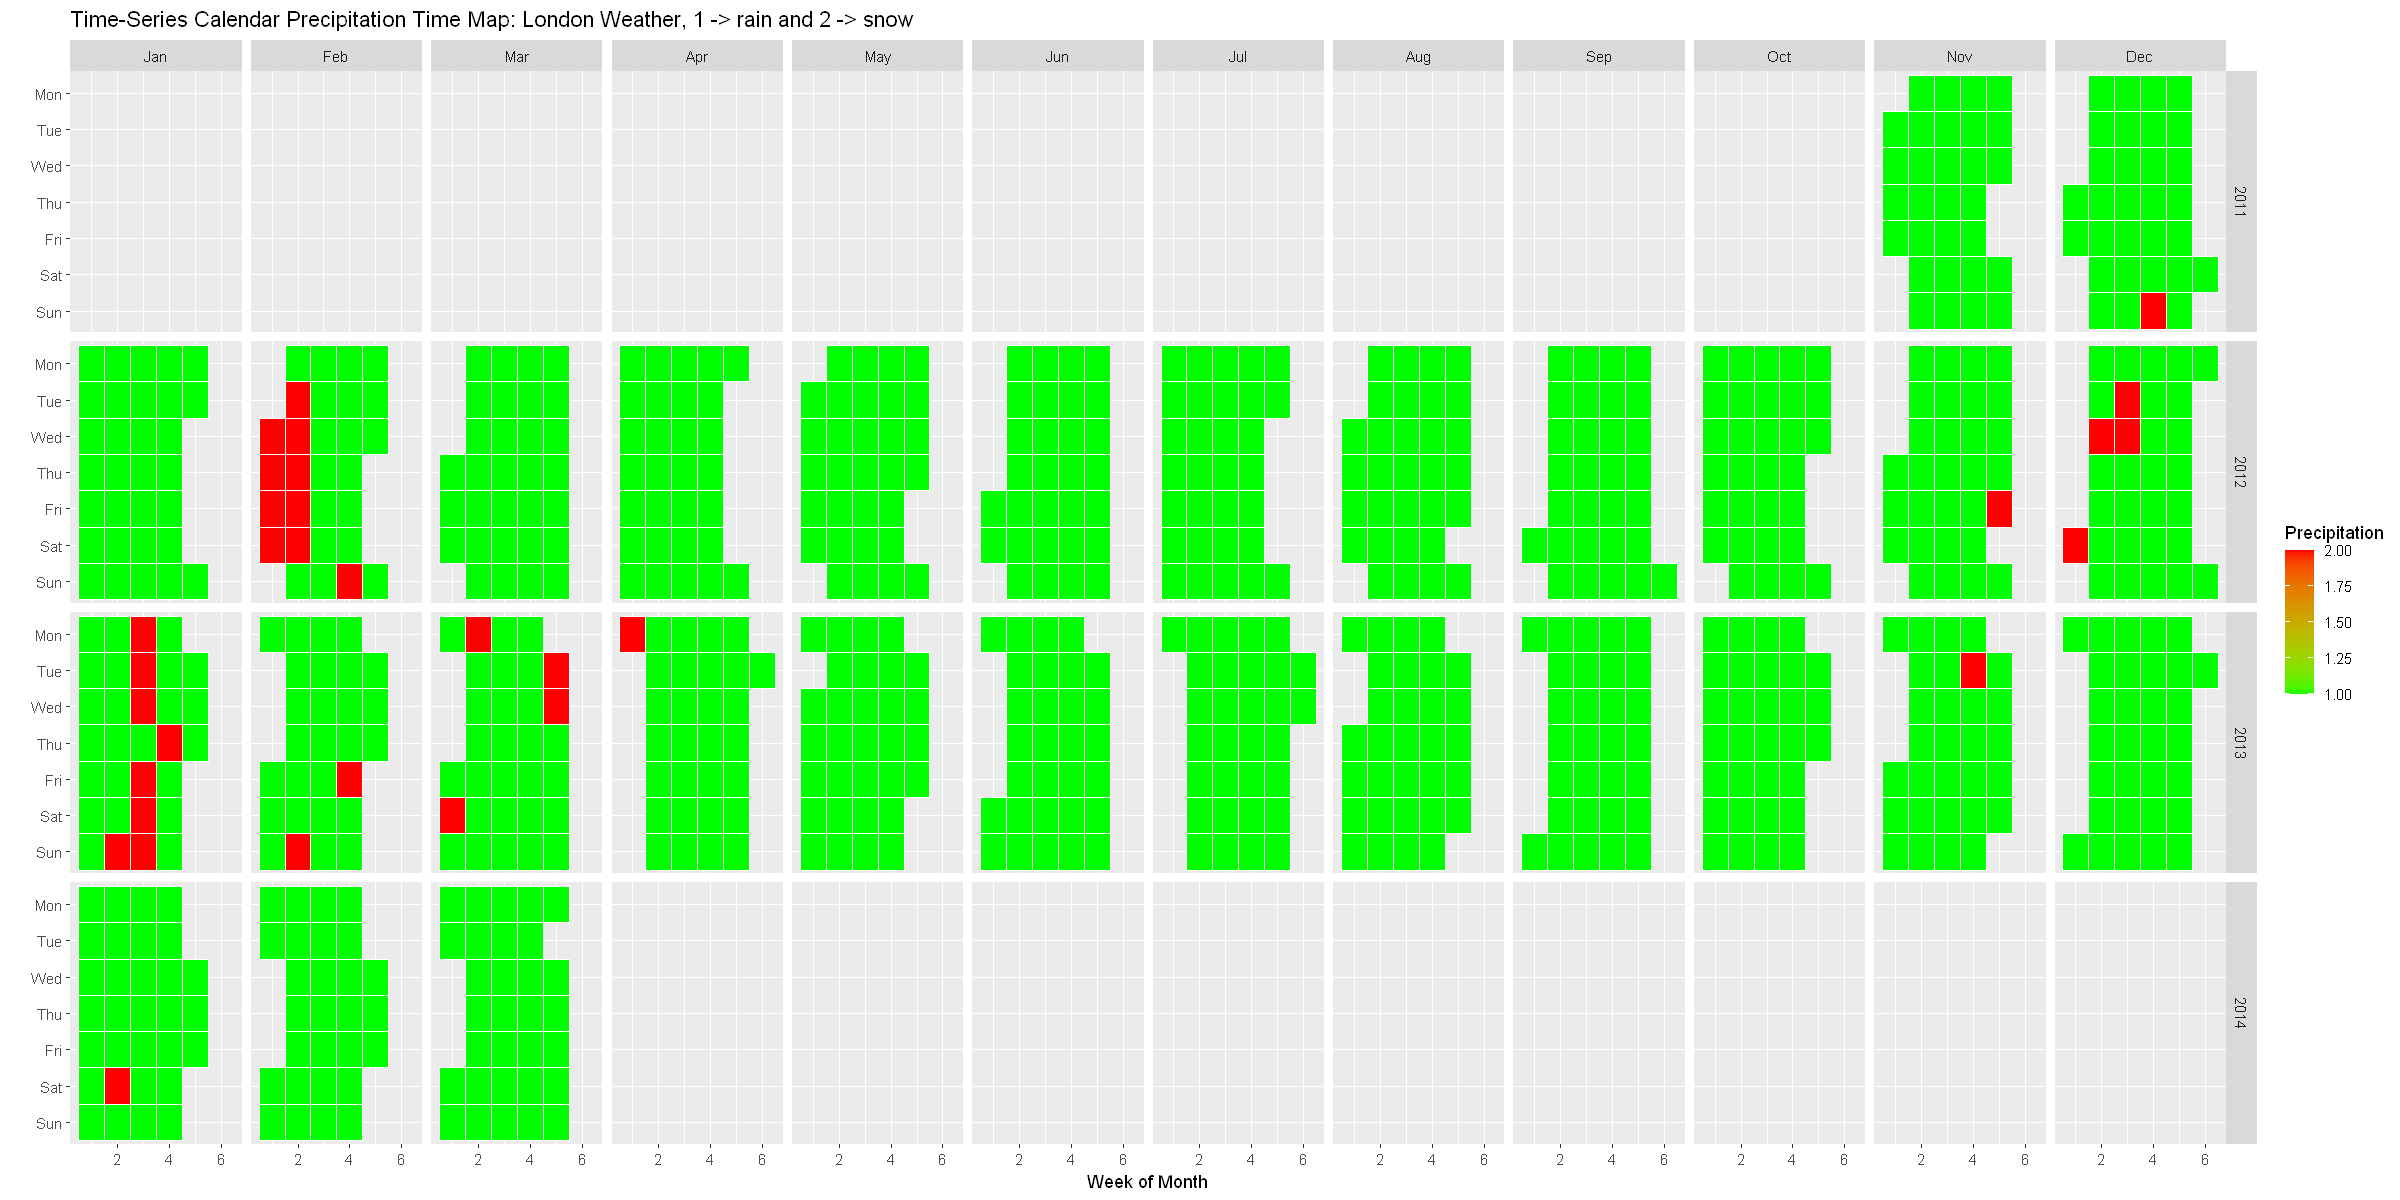

In [602]:
vars <- c("timeDate", "timeTime", "precipType")
htMapTimeTemp <- weathHourly[vars]

htMapTimeTemp$precipType <- gsub("rain", 1, htMapTimeTemp$precipType)
htMapTimeTemp$precipType <- gsub("snow", 2, htMapTimeTemp$precipType)
htMapTimeTemp$precipType <- as.numeric(htMapTimeTemp$precipType)

htMapTimeTemp$weekday = as.POSIXlt(htMapTimeTemp$timeDate)$wday #finding the day numb of the week
htMapTimeTemp$weekdayf<-factor(htMapTimeTemp$weekday,levels=rev(1:7),labels=rev(c("Mon","Tue","Wed","Thu","Fri","Sat","Sun")),ordered=TRUE) #converting the day numb to factor 
htMapTimeTemp$weekdayf[is.na(htMapTimeTemp$weekdayf)] <- "Sun"
htMapTimeTemp$monthf<-factor(month(htMapTimeTemp$timeDate),levels=as.character(1:12),labels=c("Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"),ordered=TRUE) # finding the month 
htMapTimeTemp$yearmonth<- factor(as.yearmon(htMapTimeTemp$timeDate)) #finding the year and the month from the date. Eg: Nov 2012 
htMapTimeTemp$week <- as.numeric(week(htMapTimeTemp$timeDate)) #finding the week of the year for each date 
htMapTimeTemp<-ddply(htMapTimeTemp,.(yearmonth),transform,monthweek=1+week-min(week)) #normalizing the week to start at 1 for every month 

ggplot(htMapTimeTemp, aes(monthweek, weekdayf, fill = precipType)) + 
geom_tile(colour = "white") + 
facet_grid(year(htMapTimeTemp$timeDate)~monthf) + 
scale_fill_gradient(low="green", high="red") + 
xlab("Week of Month") + ylab("") + 
ggtitle("Time-Series Calendar Precipitation Time Map: London Weather, 1 -> rain and 2 -> snow") + 
labs(fill = "Precipitation") 

#### Loads daily Energy Consumption data by time

In [610]:
hourlyEnergConsump <- dbGetQuery(dbConn, 
"
select day as timeDate, Avg_Energy_Consump
from daily_dataset_hhblocks_byHour
;
"
)

In [611]:
head(hourlyEnergConsump)

,timeDate,Avg_Energy_Consump
,<dttm>,<dbl>
1,2012-10-13,0.4210407
2,2012-10-14,0.4478637
3,2012-10-15,0.4258656
4,2012-10-16,0.4145123
5,2012-10-17,0.4079068
6,2012-10-18,0.3987657


#### Plots Electricity Consumption vs time constructs in a multi-month color coded matrix

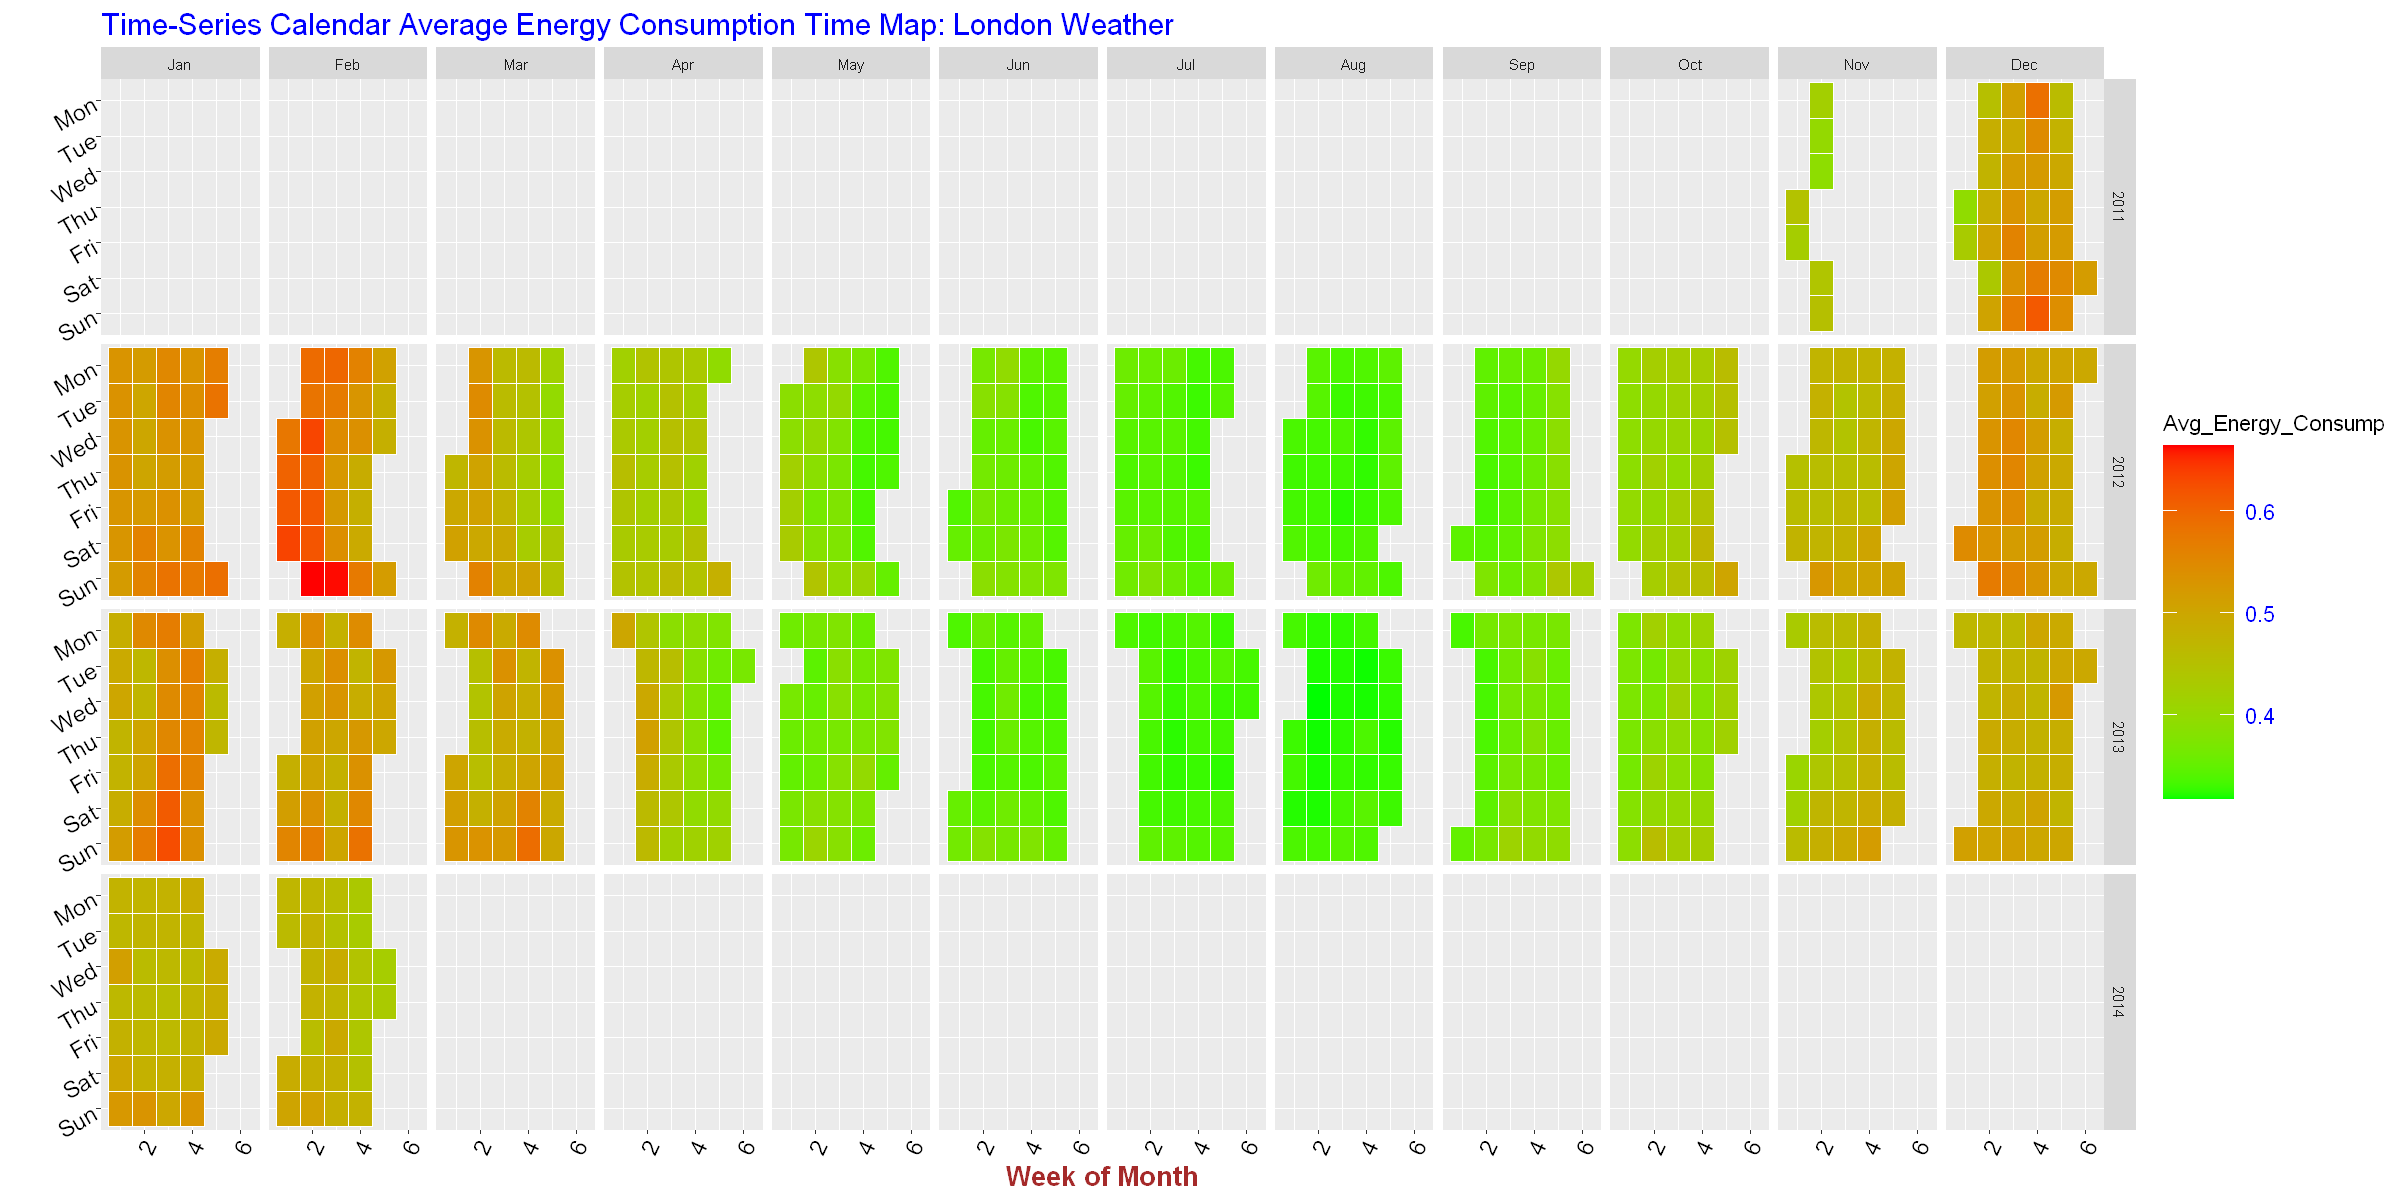

In [615]:
hourlyEnergConsump$timeDate <- trim(as.character(hourlyEnergConsump$timeDate))

hourlyEnergConsump$weekday = as.POSIXlt(hourlyEnergConsump$timeDate)$wday #finding the day numb of the week
hourlyEnergConsump$weekdayf<-factor(hourlyEnergConsump$weekday,levels=rev(1:7),labels=rev(c("Mon","Tue","Wed","Thu","Fri","Sat","Sun")),ordered=TRUE) #converting the day numb to factor 
hourlyEnergConsump$weekdayf[is.na(hourlyEnergConsump$weekdayf)] <- "Sun"
hourlyEnergConsump$monthf<-factor(month(hourlyEnergConsump$timeDate),levels=as.character(1:12),labels=c("Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"),ordered=TRUE) # finding the month 
hourlyEnergConsump$yearmonth<- factor(as.yearmon(hourlyEnergConsump$timeDate)) #finding the year and the month from the date. Eg: Nov 2012 
hourlyEnergConsump$week <- as.numeric(week(hourlyEnergConsump$timeDate)) #finding the week of the year for each date 
hourlyEnergConsump<-ddply(hourlyEnergConsump,.(yearmonth),transform,monthweek=1+week-min(week)) #normalizing the week to start at 1 for every month 

ggplot(hourlyEnergConsump, aes(monthweek, weekdayf, fill = Avg_Energy_Consump)) + 
geom_tile(colour = "white") + 
facet_grid(year(hourlyEnergConsump$timeDate)~monthf) + 
scale_fill_gradient(low="green", high="red") + 
xlab("Week of Month") + ylab("") + 
ggtitle("Time-Series Calendar Average Energy Consumption Time Map: London Weather") + 
labs(fill = "Avg_Energy_Consump")  + 
 theme(axis.text.x = element_text(size=14, angle=65, vjust=0.6, color="black"), 
        axis.text.y = element_text(size=14, angle=30, vjust=0.6, color="black"),
        axis.title=element_text(size=16, face="bold", color="brown"),
        plot.caption = element_text(color= "red", size=14, angle=0, vjust=0.6),
        plot.title = element_text(color= "blue", size=18, angle=0, vjust=0.6),
        plot.subtitle = element_text(color= "blue", size=14, angle=0, vjust=0.6, face="italic"),
        legend.title = element_text(size = 13), legend.text = element_text(color = "blue", size = 13), 
        legend.key.size = unit(1.5, "cm"), legend.key.width = unit(1.5,"cm"))

#### Plots the Average Hourly Energy Consumption of all reported ACORN groups considering the data from the entire time span for the Std tariff unaware Smart Meter owners

In [660]:
hourlyEnergConsumpbyAcornAndKnowTariff <- dbGetQuery(dbConn, 
"
select Acorn_grouped , Avg_Energy_Consump , hblock 
from daily_dataset_hhblocks_byACORN_transp
where stdorToU = 'Std'
order by Acorn_grouped , hblock 
;
"
)

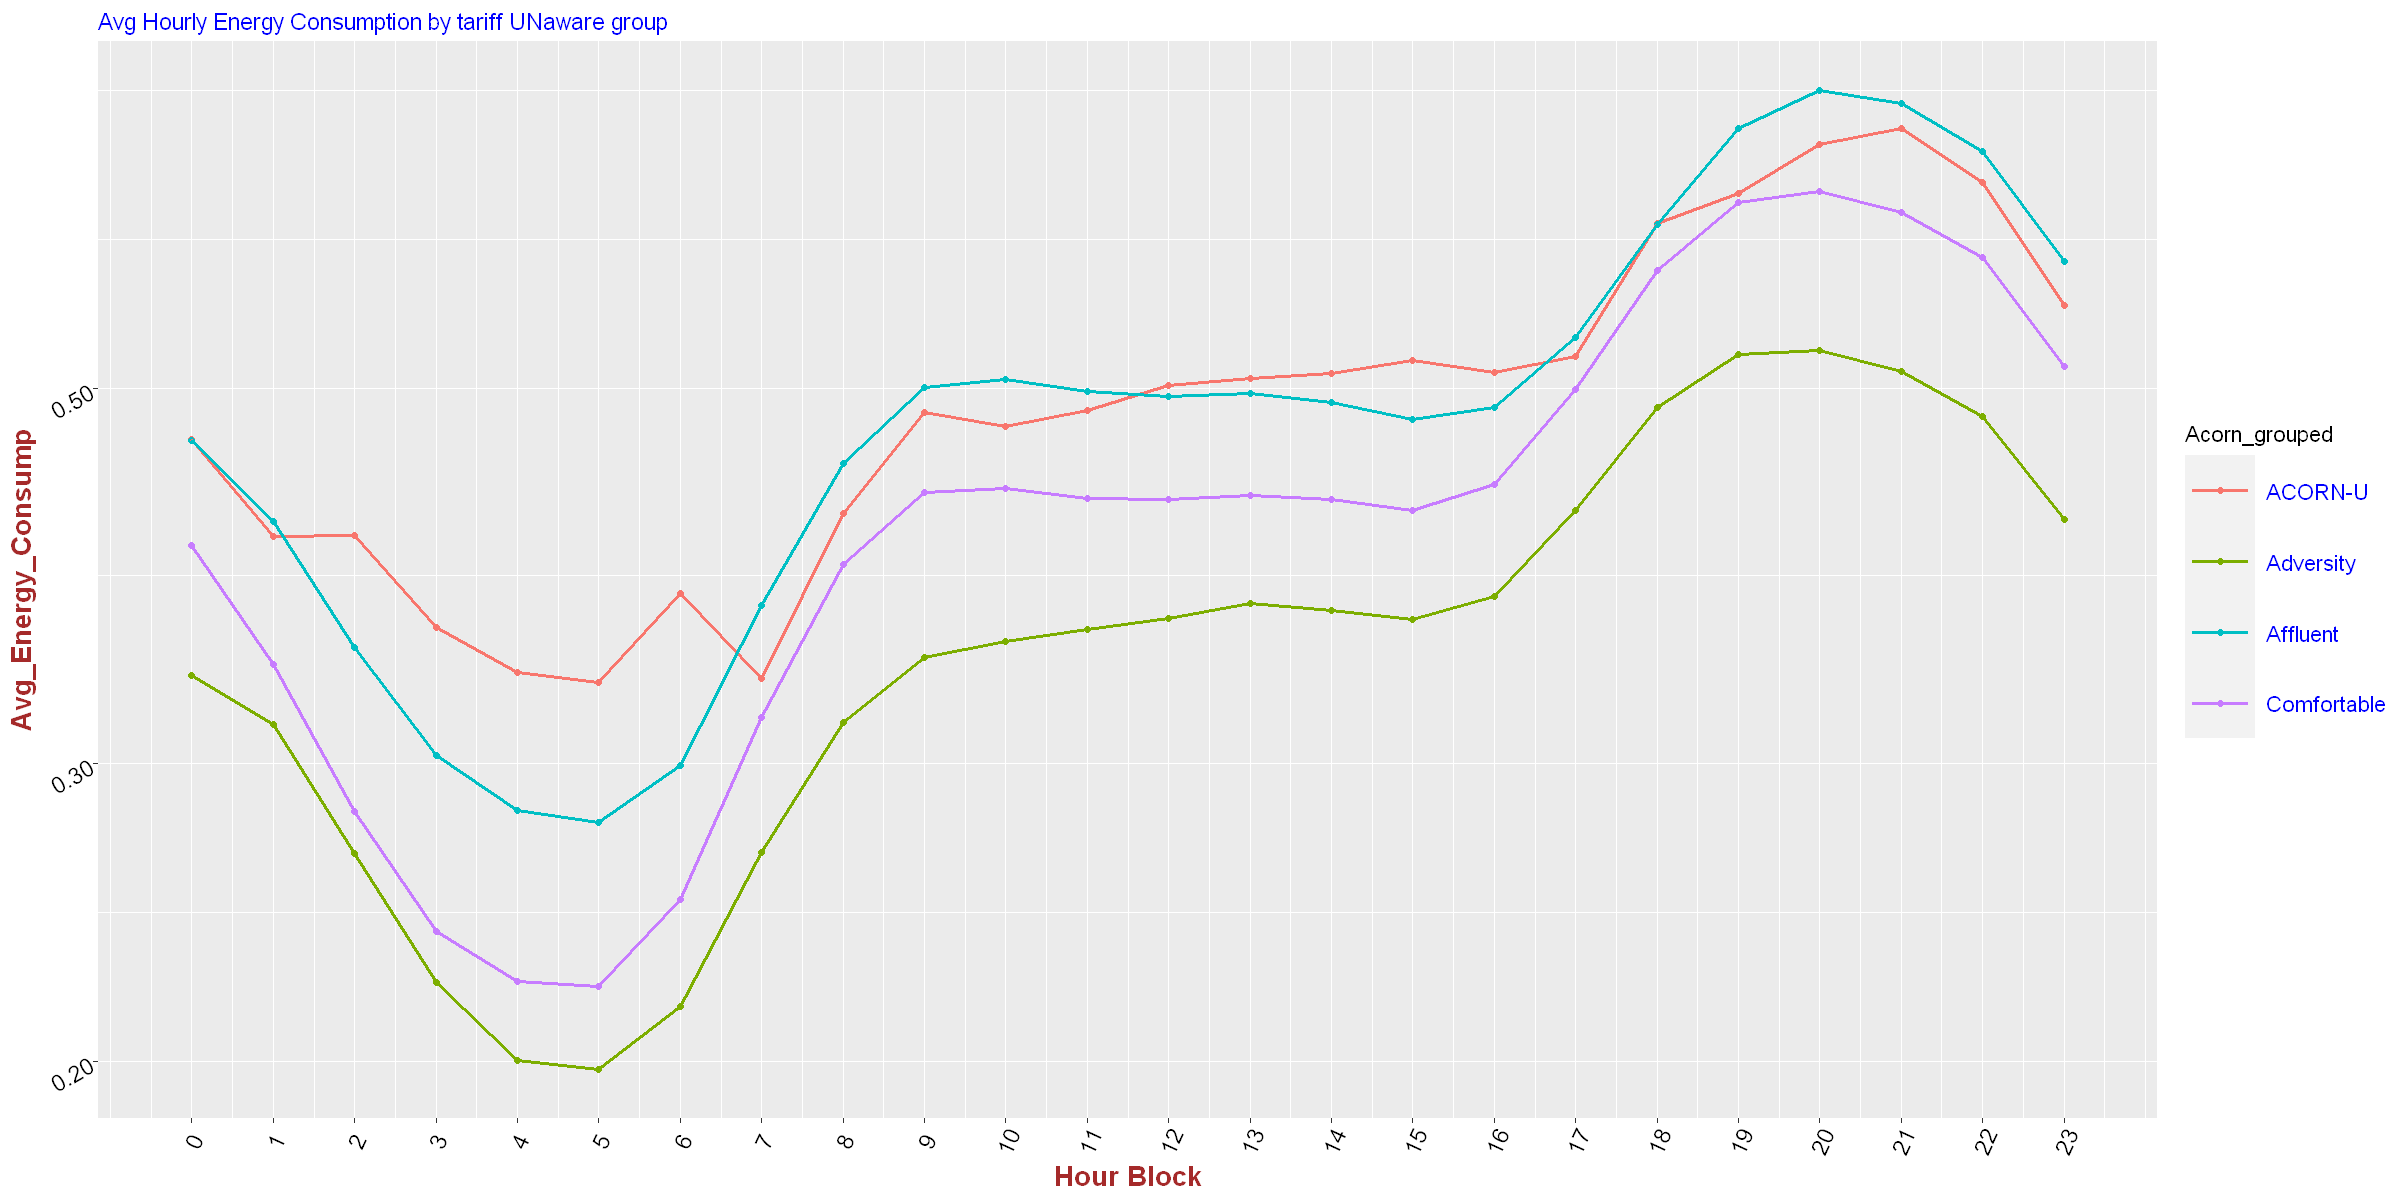

In [661]:
hourlyEnergConsumpbyAcornAndKnowTariff$Avg_Energy_Consump <- as.numeric(hourlyEnergConsumpbyAcornAndKnowTariff$Avg_Energy_Consump)
hourlyEnergConsumpbyAcornAndKnowTariff$hblock <- as.numeric(substr(as.character(hourlyEnergConsumpbyAcornAndKnowTariff$hblock),1,2))

qplot(x=hblock, y=Avg_Energy_Consump, 
           data=hourlyEnergConsumpbyAcornAndKnowTariff, 
           colour=Acorn_grouped, 
           main="Avg Hourly Energy Consumption by tariff UNaware group") +
      geom_line(size=1.0) + 
 theme(axis.text.x = element_text(size=14, angle=65, vjust=0.6, color="black"), 
        axis.text.y = element_text(size=14, angle=30, vjust=0.6, color="black"),
        axis.title=element_text(size=16, face="bold", color="brown"),
        plot.caption = element_text(color= "red", size=14, angle=0, vjust=0.6),
        plot.title = element_text(color= "blue", size=14, angle=0, vjust=0.6),
        plot.subtitle = element_text(color= "blue", size=14, angle=0, vjust=0.6, face="italic"),
        legend.title = element_text(size = 13), legend.text = element_text(color = "blue", size = 13), 
        legend.key.size = unit(1.5, "cm"), legend.key.width = unit(1.5,"cm")) +
  scale_y_log10(labels = scales::comma_format(big.mark = ',', decimal.mark = '.')) +
  xlab("Hour Block") +
  scale_x_continuous(breaks=seq(0,23,1))

#### Plots the Average Hourly Energy Consumption of all reported ACORN groups considering the data from the entire time span for the ToU tariff aware Smart Meter owners

In [662]:
hourlyEnergConsumpbyAcornAndKnowTariff <- dbGetQuery(dbConn, 
"
select Acorn_grouped , Avg_Energy_Consump , hblock 
from daily_dataset_hhblocks_byACORN_transp
where stdorToU = 'ToU'
order by Acorn_grouped , hblock 
;
"
)

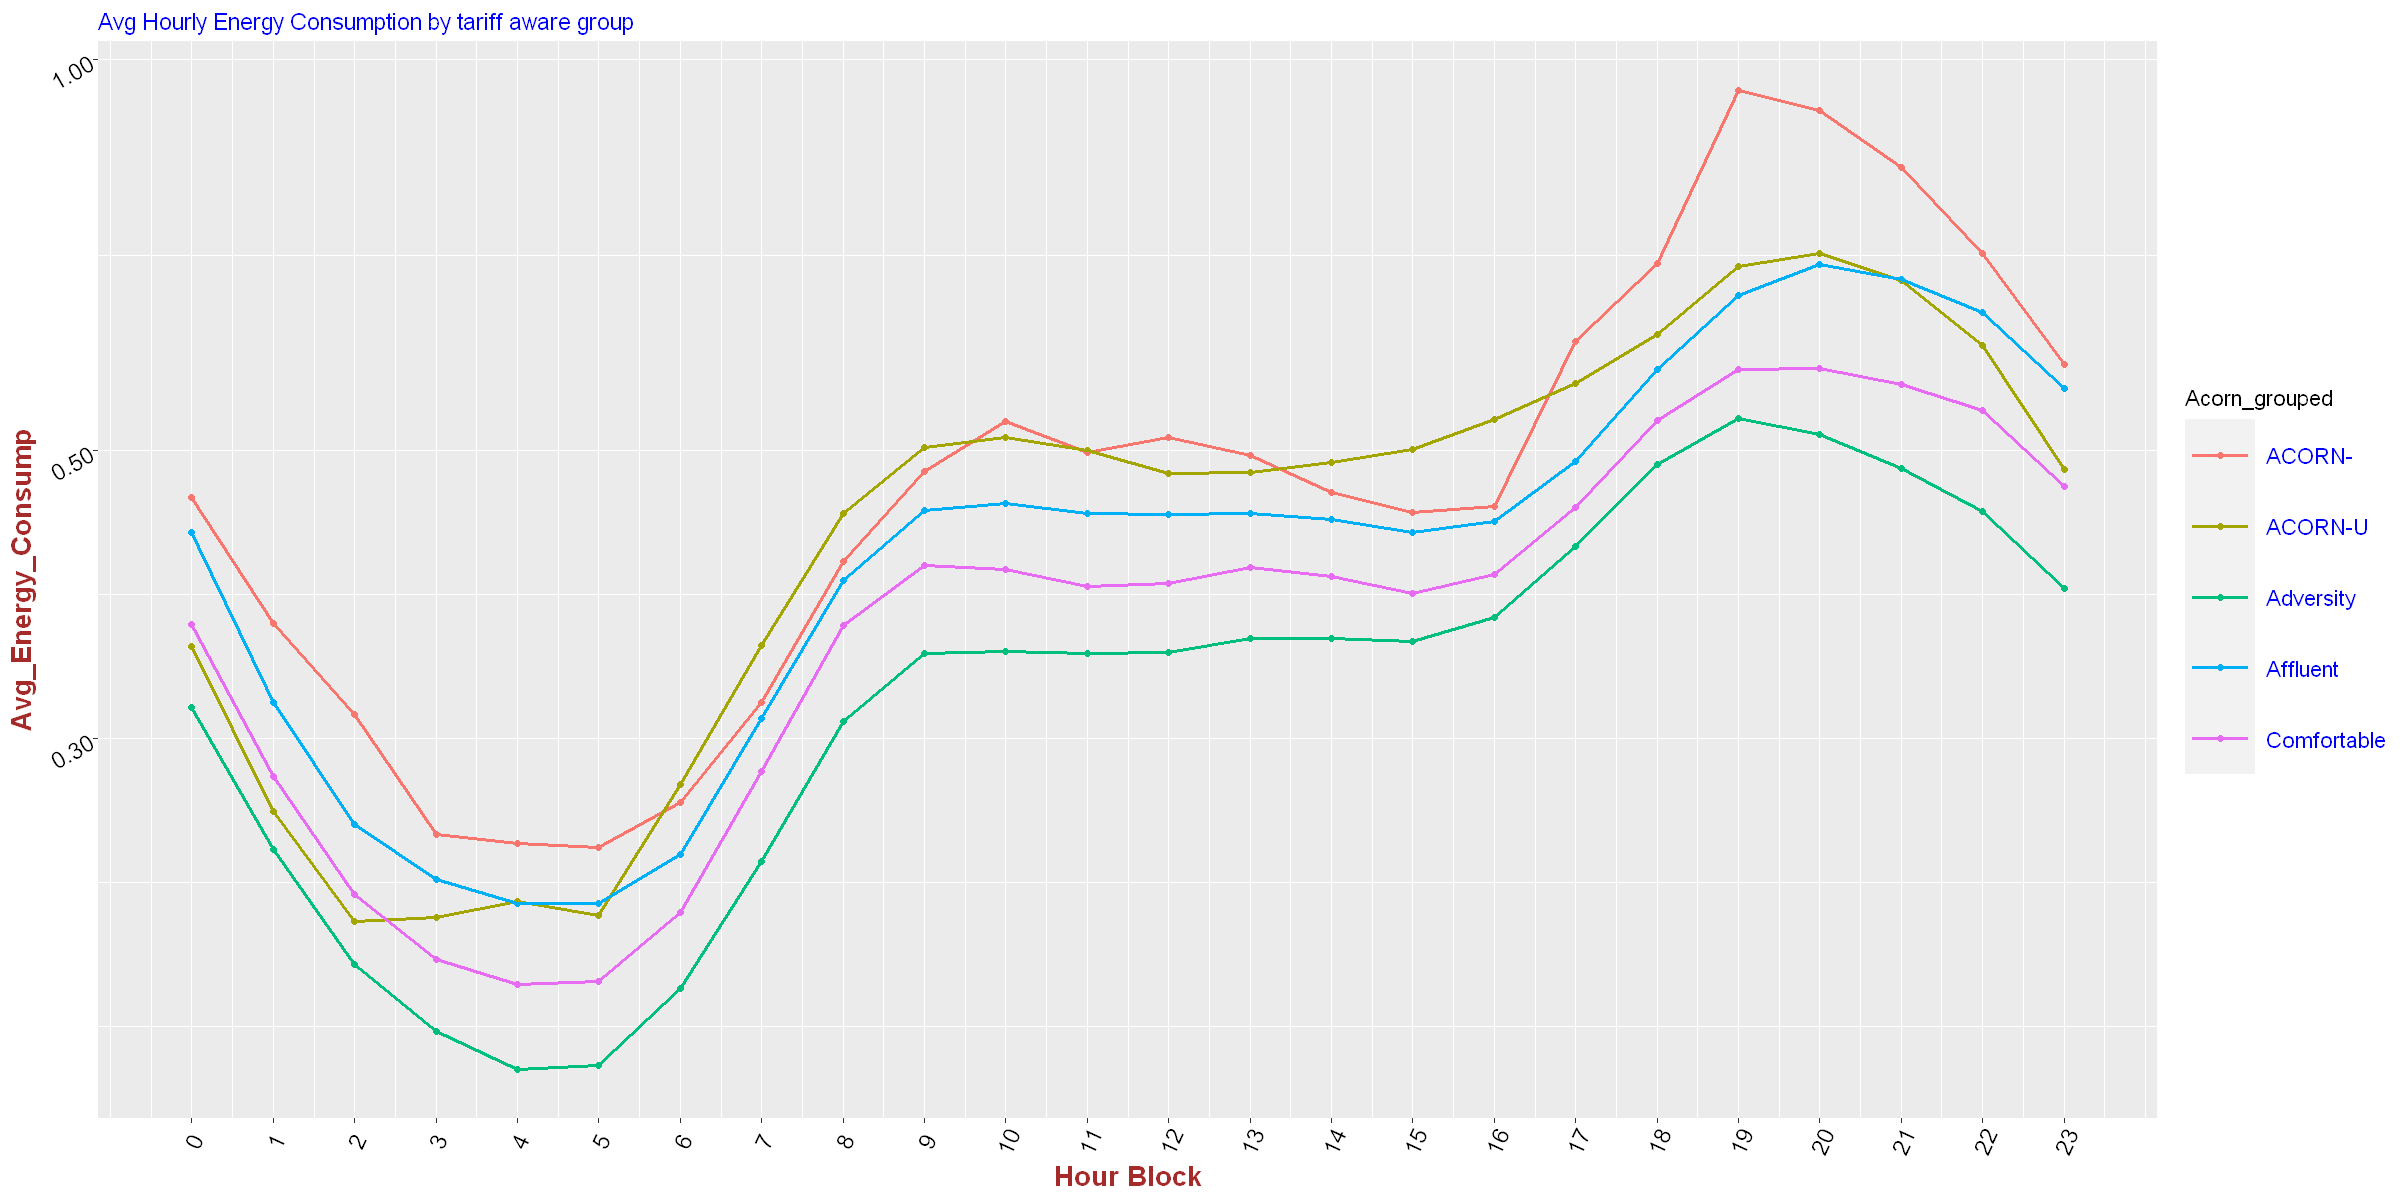

In [663]:
hourlyEnergConsumpbyAcornAndKnowTariff$Avg_Energy_Consump <- as.numeric(hourlyEnergConsumpbyAcornAndKnowTariff$Avg_Energy_Consump)
hourlyEnergConsumpbyAcornAndKnowTariff$hblock <- as.numeric(substr(as.character(hourlyEnergConsumpbyAcornAndKnowTariff$hblock),1,2))

qplot(x=hblock, y=Avg_Energy_Consump, 
           data=hourlyEnergConsumpbyAcornAndKnowTariff, 
           colour=Acorn_grouped, 
           main="Avg Hourly Energy Consumption by tariff aware group") +
      geom_line(size=1.0) + 
 theme(axis.text.x = element_text(size=14, angle=65, vjust=0.6, color="black"), 
        axis.text.y = element_text(size=14, angle=30, vjust=0.6, color="black"),
        axis.title=element_text(size=16, face="bold", color="brown"),
        plot.caption = element_text(color= "red", size=14, angle=0, vjust=0.6),
        plot.title = element_text(color= "blue", size=14, angle=0, vjust=0.6),
        plot.subtitle = element_text(color= "blue", size=14, angle=0, vjust=0.6, face="italic"),
        legend.title = element_text(size = 13), legend.text = element_text(color = "blue", size = 13), 
        legend.key.size = unit(1.5, "cm"), legend.key.width = unit(1.5,"cm")) +
  scale_y_log10(labels = scales::comma_format(big.mark = ',', decimal.mark = '.')) +
  xlab("Hour Block") +
  scale_x_continuous(breaks=seq(0,23,1))

#### Annual electricity consumption across Acorn groups by tariff range for tariff unaware cosnumers

In [714]:
acornAnnualTariffEnrgCons <- dbGetQuery(dbConn, 
"
select Acorn_grouped, Tariff, dayDate, sum(energy_sum)/sum(energy_count) as Avg_Energy_Consump
from (
    select distinct a.LCLid, a.dayDate, ih.stdorToU , ih.Acorn_grouped, c.Tariff, energy_median, energy_mean, energy_max, energy_count, energy_std, energy_sum, energy_min
    from 
    (
        select dd.*, substr(day, 1, locate(' ', day)) as dayDate
        from daily_dataset dd
    ) a
    left outer join
    SMIL.informations_households ih
    on a.LCLid = ih.LCLid 
    left outer join 
    (
    select *, substr(t.TariffDateTime, 1, locate(' ', t.TariffDateTime)) as tariffDate
    from tariffs t 
    ) c
    on a.dayDate = c.TariffDate
) d
where (stdorToU = 'std') and (Tariff != 'NA')
group by Acorn_grouped, Tariff, dayDate
;
"
)

In [715]:
head(acornAnnualTariffEnrgCons)

,Acorn_grouped,Tariff,dayDate,Avg_Energy_Consump
,<chr>,<chr>,<chr>,<dbl>
1,Affluent,Normal,2013-01-01,0.2842871
2,Affluent,Normal,2013-01-02,0.2952827
3,Affluent,Normal,2013-01-03,0.2751200
4,Affluent,Normal,2013-01-04,0.2755205
5,Affluent,Low,2013-01-04,0.2755205
6,Affluent,Normal,2013-01-05,0.2845942


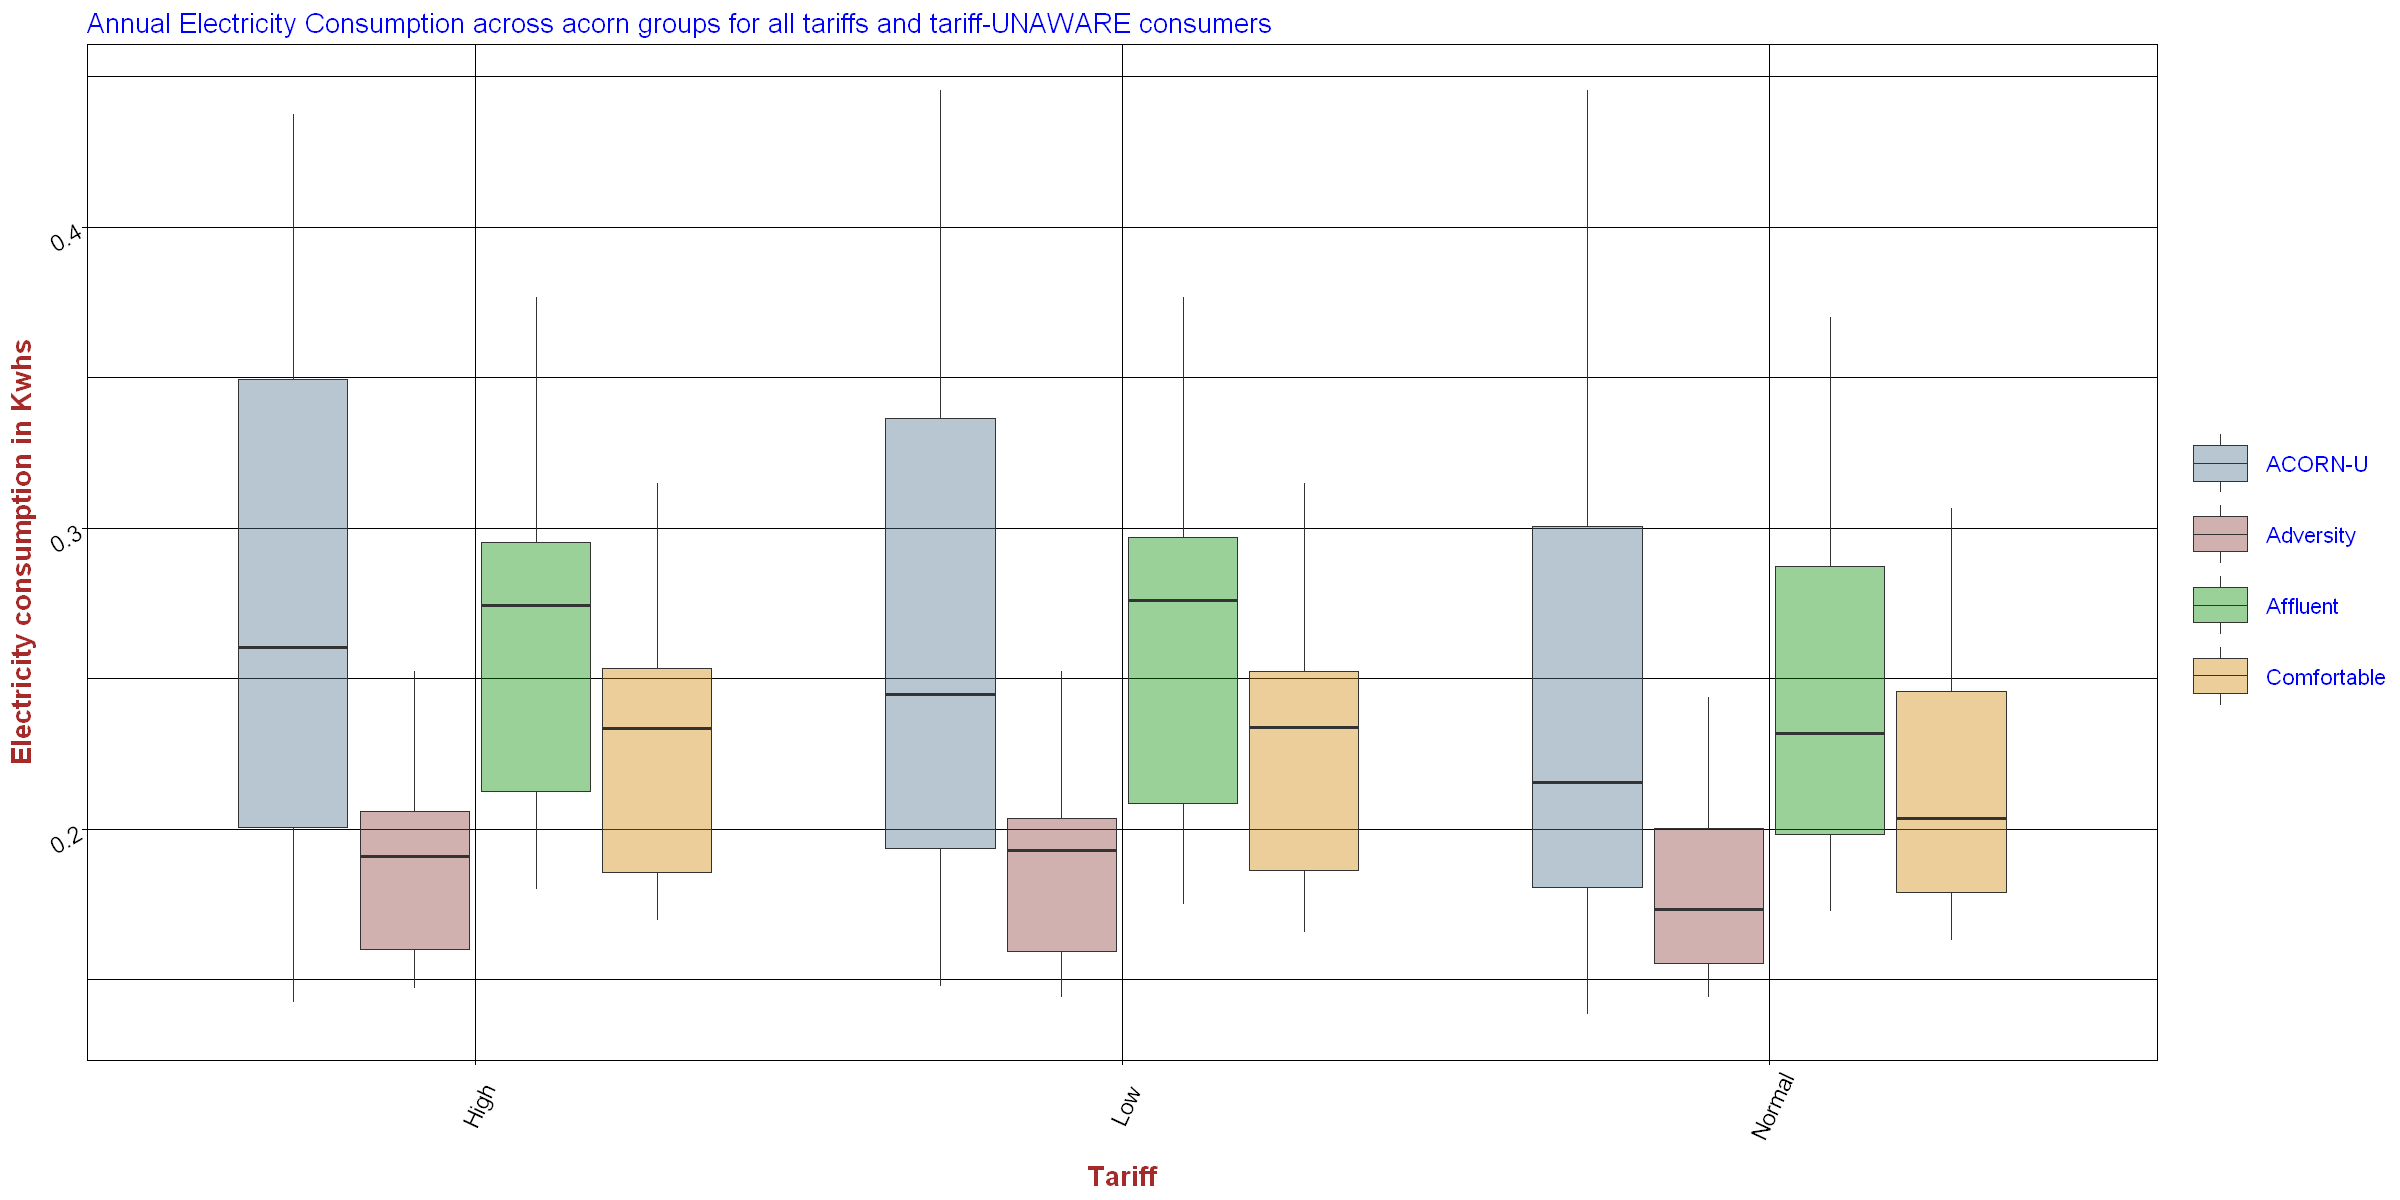

In [716]:
ggplot()+   
  geom_boxplot(data=acornAnnualTariffEnrgCons, aes(x = Tariff, y = Avg_Energy_Consump, fill=Acorn_grouped), alpha=0.4)+
  scale_fill_manual("",values=c("skyblue4","indianred4","green4","orange3"))+
  labs(title = "Annual Electricity Consumption across acorn groups for all tariffs and tariff-UNAWARE consumers",
       x = "Tariff",
       y = "Electricity consumption in Kwhs")+
  theme_linedraw() + 
 theme(axis.text.x = element_text(size=14, angle=65, vjust=0.6, color="black"), 
        axis.text.y = element_text(size=14, angle=30, vjust=0.6, color="black"),
        axis.title=element_text(size=16, face="bold", color="brown"),
        plot.caption = element_text(color= "red", size=14, angle=0, vjust=0.6),
        plot.title = element_text(color= "blue", size=16, angle=0, vjust=0.6),
        plot.subtitle = element_text(color= "blue", size=14, angle=0, vjust=0.6, face="italic"),
        legend.title = element_text(size = 13), legend.text = element_text(color = "blue", size = 13), 
        legend.key.size = unit(1.5, "cm"), legend.key.width = unit(1.5,"cm"))

#### Annual electricity consumption across Acorn groups by tariff range for tariff-Aware consumers

In [707]:
acornAnnualTariffEnrgCons <- dbGetQuery(dbConn, 
"
select Acorn_grouped, Tariff, dayDate, sum(energy_sum)/sum(energy_count) as Avg_Energy_Consump
from (
    select distinct a.LCLid, a.dayDate, ih.stdorToU , ih.Acorn_grouped, c.Tariff, energy_median, energy_mean, energy_max, energy_count, energy_std, energy_sum, energy_min
    from 
    (
        select dd.*, substr(day, 1, locate(' ', day)) as dayDate
        from daily_dataset dd
    ) a
    left outer join
    SMIL.informations_households ih
    on a.LCLid = ih.LCLid 
    left outer join 
    (
    select *, substr(t.TariffDateTime, 1, locate(' ', t.TariffDateTime)) as tariffDate
    from tariffs t 
    ) c
    on a.dayDate = c.TariffDate
) d
where (stdorToU = 'ToU') and (Tariff != 'NA')
group by Acorn_grouped, Tariff, dayDate
;
"
)

In [708]:
head(acornAnnualTariffEnrgCons)

,Acorn_grouped,Tariff,dayDate,Avg_Energy_Consump
,<chr>,<chr>,<chr>,<dbl>
1,Adversity,Normal,2013-01-01,0.1991754
2,Adversity,Normal,2013-01-02,0.1974650
3,Adversity,Normal,2013-01-03,0.1869928
4,Adversity,Normal,2013-01-04,0.1911697
5,Adversity,Low,2013-01-04,0.1911697
6,Adversity,Normal,2013-01-05,0.1800088


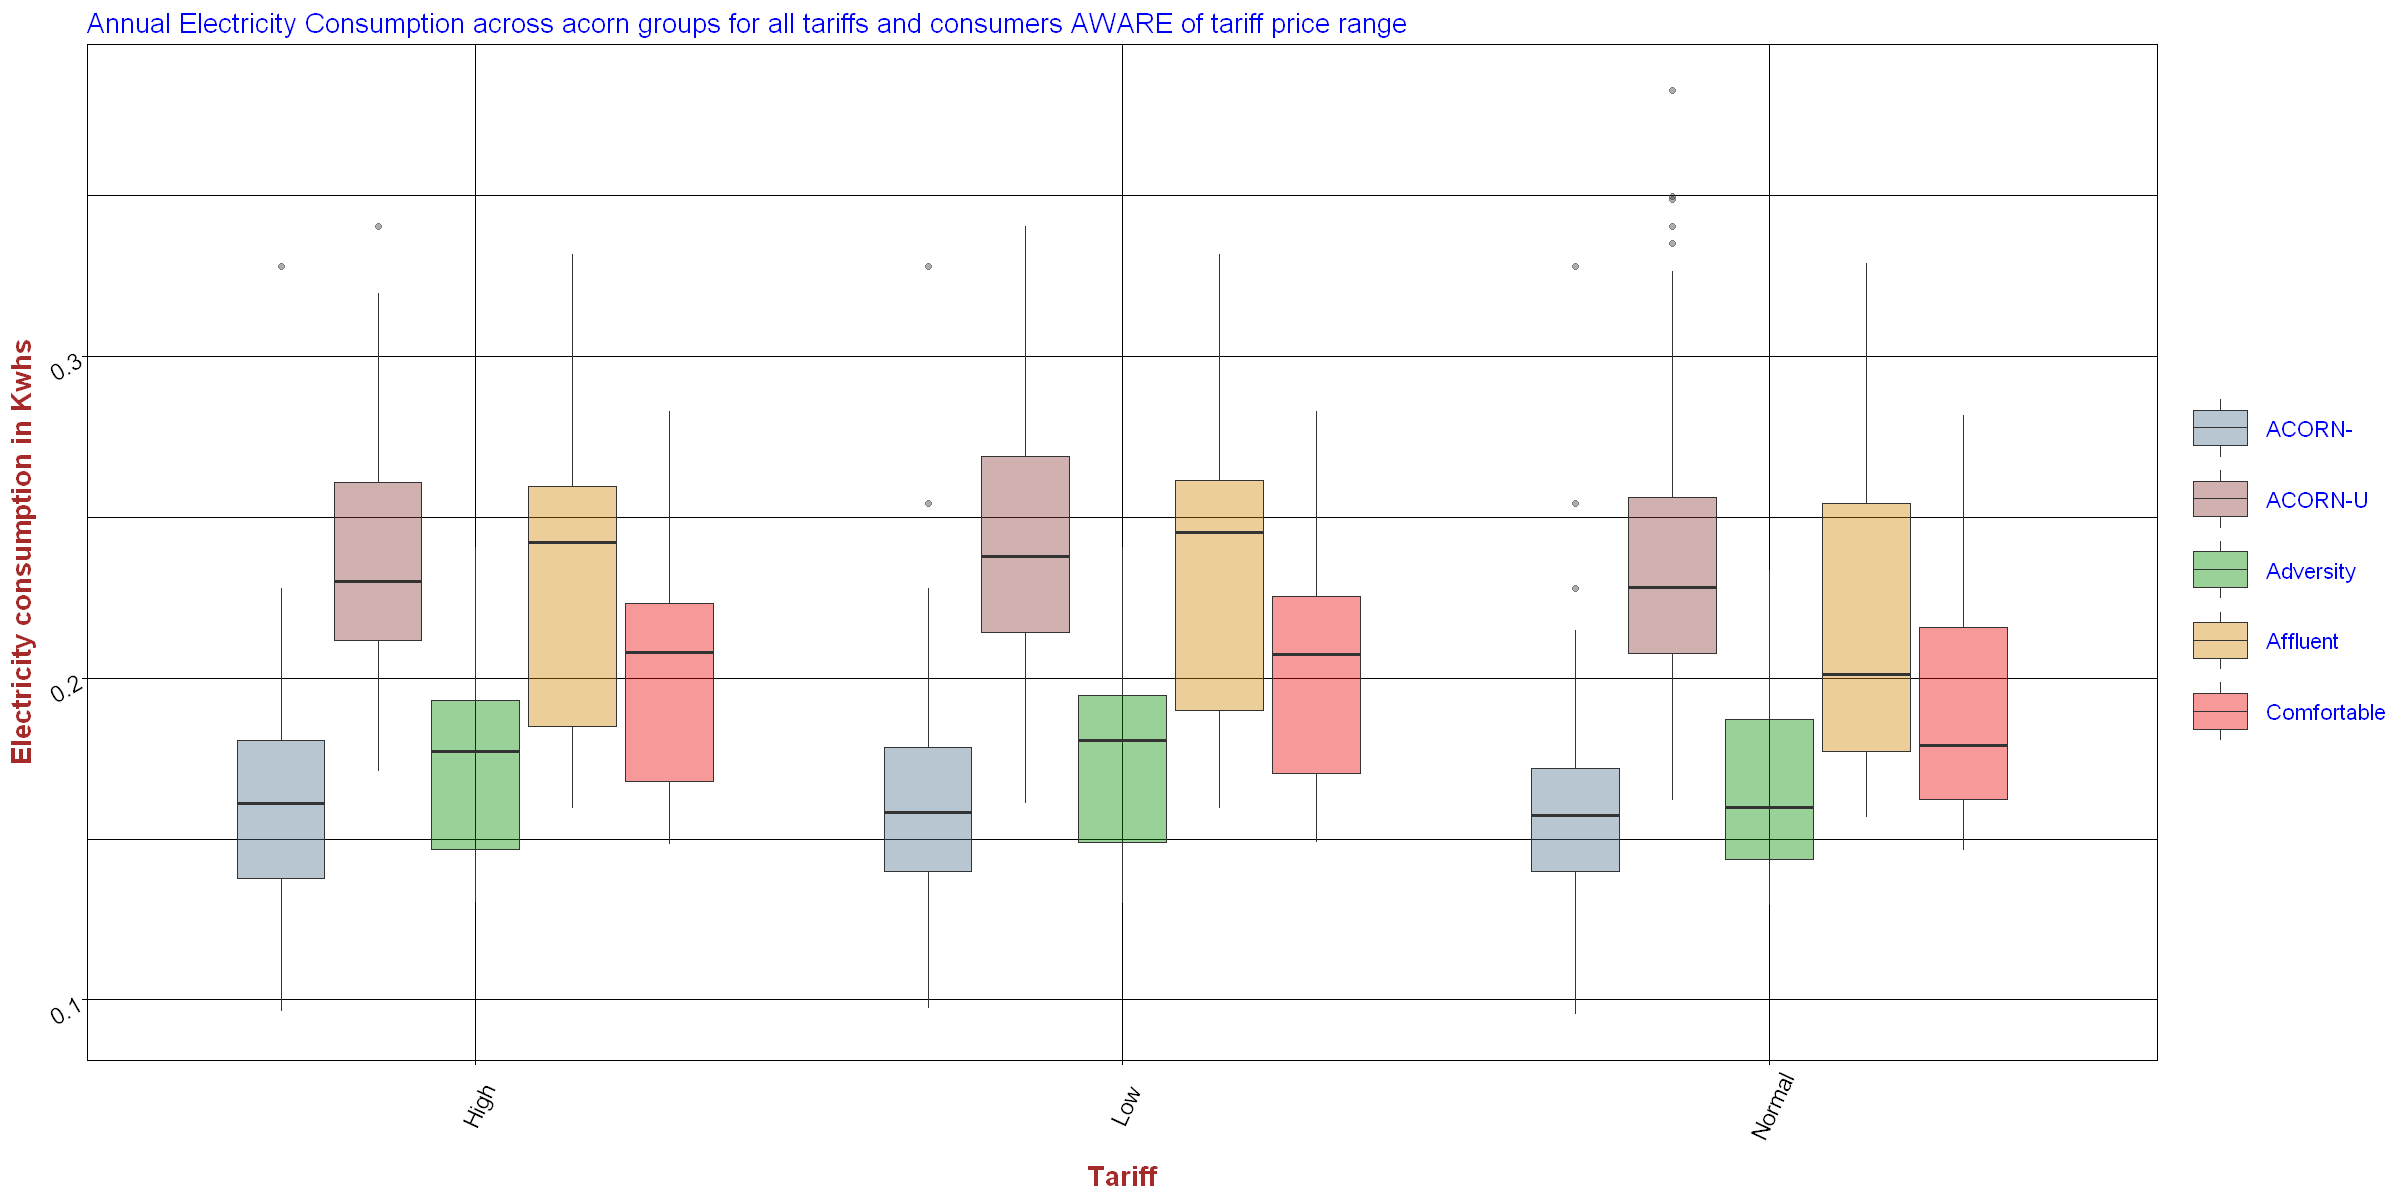

In [712]:
ggplot()+   
  geom_boxplot(data=acornAnnualTariffEnrgCons, aes(x = Tariff, y = Avg_Energy_Consump, fill=Acorn_grouped), alpha=0.4)+
  scale_fill_manual("",values=c("skyblue4","indianred4","green4","orange3","red2"))+
  labs(title = "Annual Electricity Consumption across Ccorn groups for all tariffs and consumers AWARE of tariff price range",
       x = "Tariff",
       y = "Electricity consumption in Kwhs")+
  theme_linedraw() + 
 theme(axis.text.x = element_text(size=14, angle=65, vjust=0.6, color="black"), 
        axis.text.y = element_text(size=14, angle=30, vjust=0.6, color="black"),
        axis.title=element_text(size=16, face="bold", color="brown"),
        plot.caption = element_text(color= "red", size=14, angle=0, vjust=0.6),
        plot.title = element_text(color= "blue", size=16, angle=0, vjust=0.6),
        plot.subtitle = element_text(color= "blue", size=14, angle=0, vjust=0.6, face="italic"),
        legend.title = element_text(size = 13), legend.text = element_text(color = "blue", size = 13), 
        legend.key.size = unit(1.5, "cm"), legend.key.width = unit(1.5,"cm"))

#### Heat maps permit simultaneous visualization of clusters samples and their features. First hierarchical clustering is typically performed using both rows and columns of a data matrix. The columns/rows of the data matrix are re-ordered according to the hierarchical clustering result, placing similar observations, high or low, close to each other. Then, a color scheme is applied to the visualization of the data matrix to identify the characteristic variables of each sample cluster.

#### In this viz we're attempting to cluster times (columns) and dates (rows) by 3-levels of color coded temeprature, min, medium and max. The closer to red part of the chart shows warmer times during every day. The hours have much less clusters (showing across the top) than the dates, as expected, since we have only 24 hrs in the day and more than 880 days total in the entire data set.

#### Likewise, the temperature values throughout a day are better distributed among its hours than they are within the dates of the data set. That can be visualized if one observes the colors vertically where the distrubtion is clearer as opposed to scanning it horizontally across dates.

#### Typically clustering is used to cluster a set of same category items based on their features (e.g, software features, GUI friendliness, rendering speed, installation diffculty, functionality, etc. of different applications) but, as said above, we wanted to see the results if we apply the same algorithm to a time series. In this case, we cluster dates and times based on one common feature, temperature that is.¶

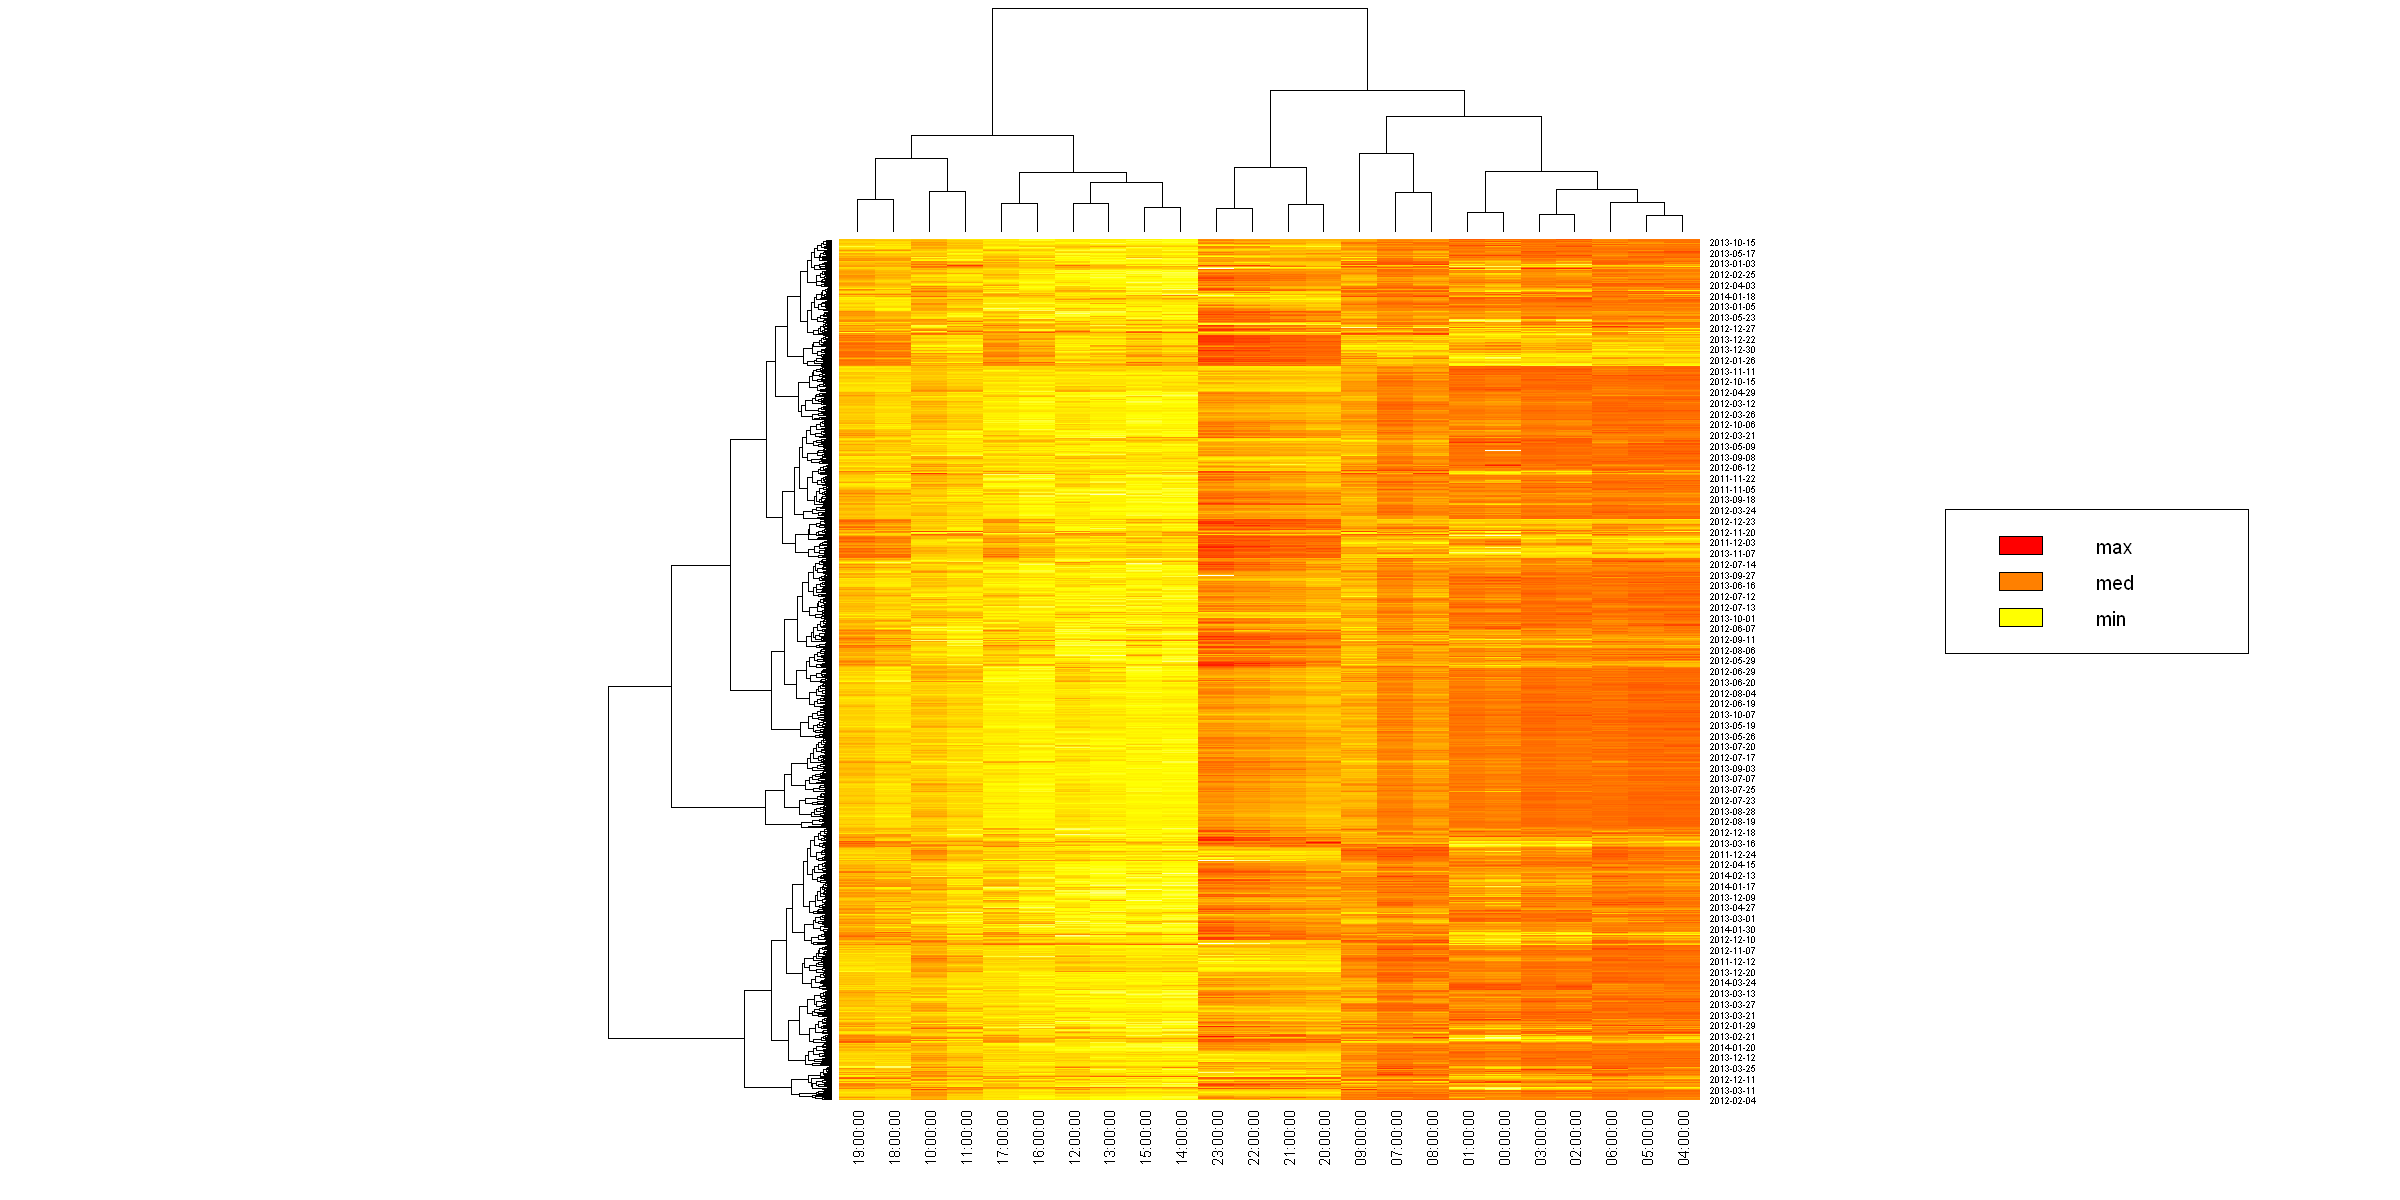

In [351]:
#weathHourly %>%
  
# Data wrangling
#as_tibble() %>%

# Change temperature to numeric
# mutate(temperature=as.numeric(temperature)) #%>%

# Heat Map
#    ggplot(aes(timeTime, timeDate, fill= temperature)) + 
#    geom_tile() +
#    theme_classic() +
#    theme(legend.position="none")

vars <- c("timeDate", "timeTime", "temperature")
htMapTimeTempVer2 <- weathHourly[vars]

dt <- spread(htMapTimeTempVer2, timeTime, temperature, fill = NA, convert = FALSE)

dt2plot <- dt[-1]
row.names(dt2plot) <- dt$timeDate 
dt2plot <- as.matrix(dt2plot)

heatmap(dt2plot, scale="row", col = heat.colors(256)) 
legend(x="right", legend=c("max", "med", "min"),fill=heat.colors(3)) 